In [ ]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from bicytok.distance_metric_funcs import KL_EMD_1D
from bicytok.imports import filter_receptor_abundances, importCITE, sample_receptor_abundances
from bicytok.selectivity_funcs import optimize_affs

import time

signal_receptor = "CD122"
sample_size = 1000
targ_cell = "Treg"
test_valencies = [(1), (2)]
dose = 1e-10
cell_categorization = "CellType2"

CITE_DF = importCITE()
assert targ_cell in CITE_DF[cell_categorization].unique()

epitopes = [
    col
    for col in CITE_DF.columns
    if col not in ["Cell", "CellType1", "CellType2", "CellType3"]
]
epitopes_df = CITE_DF[epitopes + [cell_categorization]]
epitopes_df = epitopes_df.rename(columns={cell_categorization: "Cell Type"})
sample_df = sample_receptor_abundances(
    CITE_DF=epitopes_df,
    numCells=min(sample_size, epitopes_df.shape[0]),
    targCellType=targ_cell,
)
filtered_sample_df = filter_receptor_abundances(sample_df, targ_cell, whitelist=[signal_receptor])
epitopes = filtered_sample_df.columns[:-1]

on_target_mask = (filtered_sample_df["Cell Type"] == targ_cell).to_numpy()
off_target_mask = ~on_target_mask

df_targ_cell = filtered_sample_df.loc[on_target_mask]
df_off_targ_cell = filtered_sample_df.loc[off_target_mask]

selectivity_vals = []
KL_div_vals = []
EMD_vals = []
for receptor in epitopes:
    rec_abundances = filtered_sample_df[receptor].to_numpy().reshape(-1, 1)

    KL_div_mat, EMD_mat = KL_EMD_1D(rec_abundances, on_target_mask, off_target_mask)
    KL_div = KL_div_mat[0]
    EMD = EMD_mat[0]
    KL_div_vals.append(KL_div)
    EMD_vals.append(EMD)

    for valency in test_valencies:
        time_start = time.time()

        if np.isnan(KL_div) or np.isnan(EMD):
            selectivity_vals.append(np.nan)
            continue

        model_valencies = np.array([[valency, valency]])
        targ_recs = df_targ_cell[[signal_receptor] + [receptor]].to_numpy()
        off_targ_recs = df_off_targ_cell[[signal_receptor] + [receptor]].to_numpy()
        opt_selec, _, _ = optimize_affs(
            targRecs=targ_recs,
            offTargRecs=off_targ_recs,
            dose=dose,
            valencies=model_valencies,
            
        )
        selectivity_vals.append(1 / opt_selec)

        time_end = time.time()
        print(f"Processing time for {receptor} (Valency {valency}): {time_end - time_start} seconds")

valency_map = {1: "Valency 2", 2: "Valency 4"}
valency_labels = [valency_map[v] for _ in epitopes for v in test_valencies]
metrics_df = pd.DataFrame(
    {
        "Receptor Pair": [
            str(receptor) for receptor in epitopes for _ in test_valencies
        ],
        "Valency": valency_labels,
        "KL Divergence": np.repeat(KL_div_vals, len(test_valencies)),
        "EMD": np.repeat(EMD_vals, len(test_valencies)),
        "Selectivity": selectivity_vals,
    }
)

unique_receptors_df = pd.DataFrame(
    {
        "Receptor Pair": [str(receptor) for receptor in epitopes],
        "KL Divergence": [KL_div_val for KL_div_val in KL_div_vals],
        "EMD": [EMD_val for EMD_val in EMD_vals],
    }
)
unique_receptors_df = unique_receptors_df.fillna(0)

top_kl_indices = unique_receptors_df["KL Divergence"].nlargest(5).index.tolist()
top_kl_receptors = unique_receptors_df.iloc[top_kl_indices][
    "Receptor Pair"
].tolist()

top_emd_indices = unique_receptors_df["EMD"].nlargest(5).index.tolist()
top_emd_receptors = unique_receptors_df.iloc[top_emd_indices][
    "Receptor Pair"
].tolist()

# Get top 5 selectivity for each valency
top_selectivity_receptors = {}
for valency in ["Valency 2", "Valency 4"]:
    valency_data = metrics_df[metrics_df["Valency"] == valency].dropna(subset=["Selectivity"])
    top_selectivity_receptors[valency] = valency_data.nlargest(5, "Selectivity")["Receptor Pair"].tolist()

metrics_df_kl_filtered = metrics_df[
    metrics_df["Receptor Pair"].isin(top_kl_receptors)
]
metrics_df_emd_filtered = metrics_df[
    metrics_df["Receptor Pair"].isin(top_emd_receptors)
]

Processing time for CCR10 (Valency 1): 40.785467863082886 seconds
Processing time for CCR10 (Valency 2): 9.949804306030273 seconds
Processing time for CD106 (Valency 1): 10.880118131637573 seconds
Processing time for CD106 (Valency 2): 9.96094274520874 seconds
Processing time for CD109 (Valency 1): 17.502524375915527 seconds
Processing time for CD109 (Valency 2): 12.171753883361816 seconds
Processing time for CD122 (Valency 1): 11.72572636604309 seconds
Processing time for CD122 (Valency 2): 8.423203229904175 seconds
Processing time for CD138-1 (Valency 1): 26.423027753829956 seconds
Processing time for CD138-1 (Valency 2): 14.394439697265625 seconds
Processing time for CD138-2 (Valency 1): 16.042452812194824 seconds
Processing time for CD138-2 (Valency 2): 9.215662717819214 seconds
Processing time for CD144 (Valency 1): 28.42258620262146 seconds
Processing time for CD144 (Valency 2): 11.242433309555054 seconds
Processing time for CD194 (Valency 1): 11.486515998840332 seconds
Processin

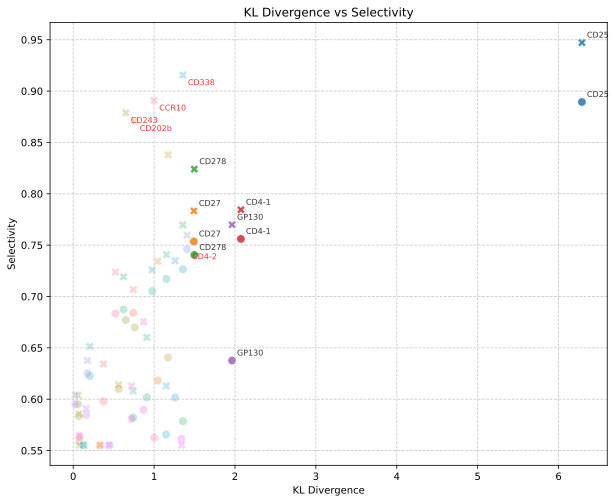

In [ ]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=metrics_df,
    x="KL Divergence",
    y="Selectivity",
    hue="Receptor Pair",
    style="Valency",
    s=70,
    legend=False,
    alpha=0.3,
)

sns.scatterplot(
    data=metrics_df_kl_filtered,
    x="KL Divergence",
    y="Selectivity",
    hue="Receptor Pair",
    style="Valency",
    s=70,
    legend=False,
    alpha=0.8,
)

# Add labels for top 5 KL divergence receptors
for receptor in top_kl_receptors:
    receptor_data = metrics_df_kl_filtered[metrics_df_kl_filtered["Receptor Pair"] == receptor]
    for _, row in receptor_data.iterrows():
        plt.annotate(receptor, (row["KL Divergence"], row["Selectivity"]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# Add labels for top 5 selectivity receptors
for valency in ["Valency 2", "Valency 4"]:
    for receptor in top_selectivity_receptors[valency]:
        if receptor not in top_kl_receptors:  # Avoid duplicate labels
            receptor_data = metrics_df[(metrics_df["Receptor Pair"] == receptor) & 
                                     (metrics_df["Valency"] == valency)].dropna(subset=["Selectivity"])
            if not receptor_data.empty:
                row = receptor_data.iloc[0]
                plt.annotate(receptor, (row["KL Divergence"], row["Selectivity"]), 
                           xytext=(5, -10), textcoords='offset points', fontsize=8, alpha=0.8, color='red')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("KL Divergence")
plt.ylabel("Selectivity")
plt.title("KL Divergence vs Selectivity")
plt.show()

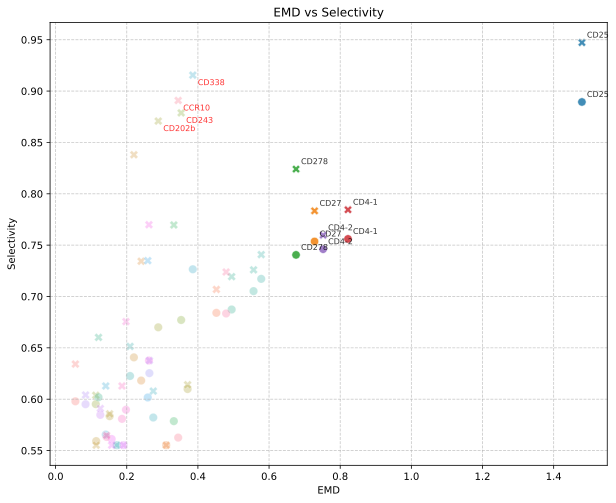

In [ ]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=metrics_df,
    x="EMD",
    y="Selectivity",
    hue="Receptor Pair",
    style="Valency",
    s=70,
    legend=False,
    alpha=0.3,
)

sns.scatterplot(
    data=metrics_df_emd_filtered,
    x="EMD",
    y="Selectivity",
    hue="Receptor Pair",
    style="Valency",
    s=70,
    legend=False,
    alpha=0.8,
)

# Add labels for top 5 EMD receptors
for receptor in top_emd_receptors:
    receptor_data = metrics_df_emd_filtered[metrics_df_emd_filtered["Receptor Pair"] == receptor]
    for _, row in receptor_data.iterrows():
        plt.annotate(receptor, (row["EMD"], row["Selectivity"]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# Add labels for top 5 selectivity receptors
for valency in ["Valency 2", "Valency 4"]:
    for receptor in top_selectivity_receptors[valency]:
        if receptor not in top_emd_receptors:  # Avoid duplicate labels
            receptor_data = metrics_df[(metrics_df["Receptor Pair"] == receptor) & 
                                     (metrics_df["Valency"] == valency)].dropna(subset=["Selectivity"])
            if not receptor_data.empty:
                row = receptor_data.iloc[0]
                plt.annotate(receptor, (row["EMD"], row["Selectivity"]), 
                           xytext=(5, -10), textcoords='offset points', fontsize=8, alpha=0.8, color='red')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("EMD")
plt.ylabel("Selectivity")
plt.title("EMD vs Selectivity")
plt.show()

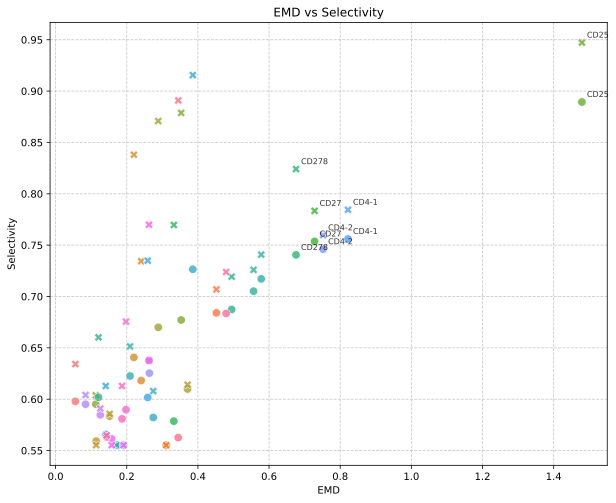

In [ ]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=metrics_df,
    x="EMD",
    y="Selectivity",
    hue="Receptor Pair",
    style="Valency",
    s=70,
    legend=False,
    alpha=0.8,
)

# sns.scatterplot(
#     data=metrics_df_emd_filtered,
#     x="EMD",
#     y="Selectivity",
#     hue="Receptor Pair",
#     style="Valency",
#     s=70,
#     legend=False,
#     alpha=0.8,
# )

# Add labels for top 5 EMD receptors
for receptor in top_emd_receptors:
    receptor_data = metrics_df_emd_filtered[metrics_df_emd_filtered["Receptor Pair"] == receptor]
    for _, row in receptor_data.iterrows():
        plt.annotate(receptor, (row["EMD"], row["Selectivity"]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# Add labels for top 5 selectivity receptors
# for valency in ["Valency 2", "Valency 4"]:
#     for receptor in top_selectivity_receptors[valency]:
#         if receptor not in top_emd_receptors:  # Avoid duplicate labels
#             receptor_data = metrics_df[(metrics_df["Receptor Pair"] == receptor) & 
#                                      (metrics_df["Valency"] == valency)].dropna(subset=["Selectivity"])
#             if not receptor_data.empty:
#                 row = receptor_data.iloc[0]
#                 plt.annotate(receptor, (row["EMD"], row["Selectivity"]), 
#                            xytext=(5, -10), textcoords='offset points', fontsize=8, alpha=0.8, color='red')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("EMD")
plt.ylabel("Selectivity")
plt.title("EMD vs Selectivity")
plt.show()

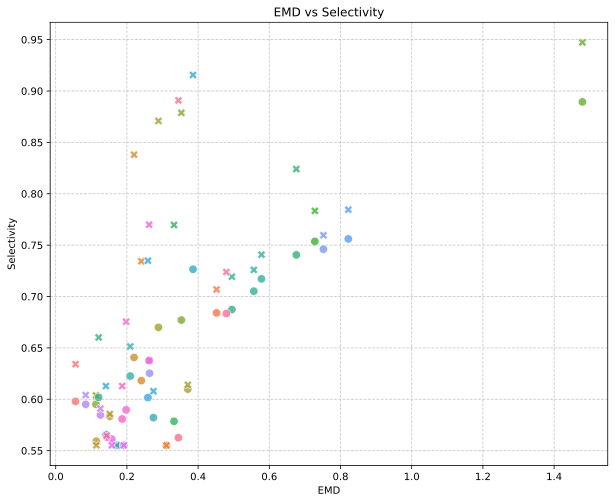

In [ ]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=metrics_df,
    x="EMD",
    y="Selectivity",
    hue="Receptor Pair",
    style="Valency",
    s=70,
    legend=False,
    alpha=0.8,
)

# sns.scatterplot(
#     data=metrics_df_emd_filtered,
#     x="EMD",
#     y="Selectivity",
#     hue="Receptor Pair",
#     style="Valency",
#     s=70,
#     legend=False,
#     alpha=0.8,
# )

# Add labels for top 5 EMD receptors
# for receptor in top_emd_receptors:
#     receptor_data = metrics_df_emd_filtered[metrics_df_emd_filtered["Receptor Pair"] == receptor]
#     for _, row in receptor_data.iterrows():
#         plt.annotate(receptor, (row["EMD"], row["Selectivity"]), 
#                     xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# Add labels for top 5 selectivity receptors
# for valency in ["Valency 2", "Valency 4"]:
#     for receptor in top_selectivity_receptors[valency]:
#         if receptor not in top_emd_receptors:  # Avoid duplicate labels
#             receptor_data = metrics_df[(metrics_df["Receptor Pair"] == receptor) & 
#                                      (metrics_df["Valency"] == valency)].dropna(subset=["Selectivity"])
#             if not receptor_data.empty:
#                 row = receptor_data.iloc[0]
#                 plt.annotate(receptor, (row["EMD"], row["Selectivity"]), 
#                            xytext=(5, -10), textcoords='offset points', fontsize=8, alpha=0.8, color='red')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("EMD")
plt.ylabel("Selectivity")
plt.title("EMD vs Selectivity")
plt.show()

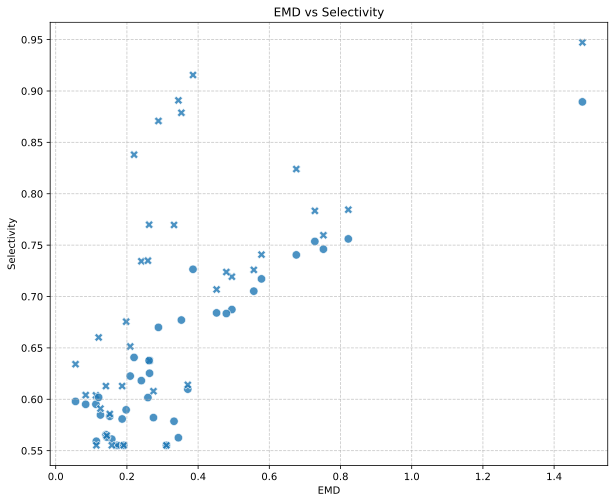

In [ ]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=metrics_df,
    x="EMD",
    y="Selectivity",
    # hue="Receptor Pair",
    style="Valency",
    s=70,
    legend=False,
    alpha=0.8,
)

# sns.scatterplot(
#     data=metrics_df_emd_filtered,
#     x="EMD",
#     y="Selectivity",
#     hue="Receptor Pair",
#     style="Valency",
#     s=70,
#     legend=False,
#     alpha=0.8,
# )

# Add labels for top 5 EMD receptors
# for receptor in top_emd_receptors:
#     receptor_data = metrics_df_emd_filtered[metrics_df_emd_filtered["Receptor Pair"] == receptor]
#     for _, row in receptor_data.iterrows():
#         plt.annotate(receptor, (row["EMD"], row["Selectivity"]), 
#                     xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# Add labels for top 5 selectivity receptors
# for valency in ["Valency 2", "Valency 4"]:
#     for receptor in top_selectivity_receptors[valency]:
#         if receptor not in top_emd_receptors:  # Avoid duplicate labels
#             receptor_data = metrics_df[(metrics_df["Receptor Pair"] == receptor) & 
#                                      (metrics_df["Valency"] == valency)].dropna(subset=["Selectivity"])
#             if not receptor_data.empty:
#                 row = receptor_data.iloc[0]
#                 plt.annotate(receptor, (row["EMD"], row["Selectivity"]), 
#                            xytext=(5, -10), textcoords='offset points', fontsize=8, alpha=0.8, color='red')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("EMD")
plt.ylabel("Selectivity")
plt.title("EMD vs Selectivity")
plt.show()

In [ ]:
top_kl_indices = unique_receptors_df["KL Divergence"].nlargest(15).index.tolist()
top_kl_receptors = unique_receptors_df.iloc[top_kl_indices][
    "Receptor Pair"
].tolist()

top_emd_indices = unique_receptors_df["EMD"].nlargest(15).index.tolist()
top_emd_receptors = unique_receptors_df.iloc[top_emd_indices][
    "Receptor Pair"
].tolist()

# Get top 5 selectivity for each valency
top_selectivity_receptors = {}
for valency in ["Valency 2", "Valency 4"]:
    valency_data = metrics_df[metrics_df["Valency"] == valency].dropna(subset=["Selectivity"])
    top_selectivity_receptors[valency] = valency_data.nlargest(5, "Selectivity")["Receptor Pair"].tolist()

metrics_df_kl_filtered = metrics_df[
    metrics_df["Receptor Pair"].isin(top_kl_receptors)
]
metrics_df_emd_filtered = metrics_df[
    metrics_df["Receptor Pair"].isin(top_emd_receptors)
]

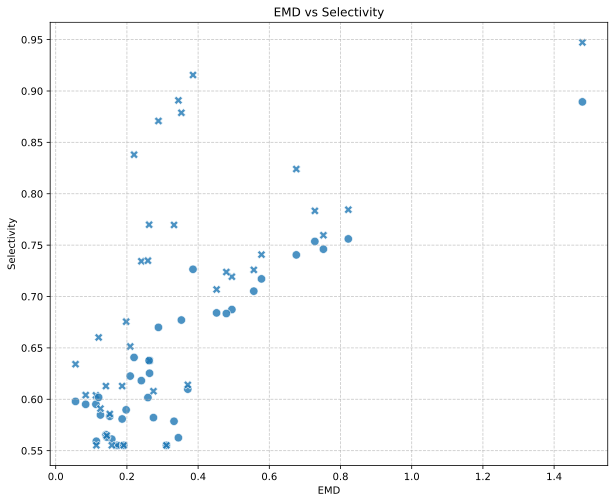

In [ ]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=metrics_df,
    x="EMD",
    y="Selectivity",
    # hue="Receptor Pair",
    style="Valency",
    s=70,
    legend=False,
    alpha=0.8,
)

# sns.scatterplot(
#     data=metrics_df_emd_filtered,
#     x="EMD",
#     y="Selectivity",
#     hue="Receptor Pair",
#     style="Valency",
#     s=70,
#     legend=False,
#     alpha=0.8,
# )

# Add labels for top 5 EMD receptors
# for receptor in top_emd_receptors:
#     receptor_data = metrics_df_emd_filtered[metrics_df_emd_filtered["Receptor Pair"] == receptor]
#     for _, row in receptor_data.iterrows():
#         plt.annotate(receptor, (row["EMD"], row["Selectivity"]), 
#                     xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# Add labels for top 5 selectivity receptors
# for valency in ["Valency 2", "Valency 4"]:
#     for receptor in top_selectivity_receptors[valency]:
#         if receptor not in top_emd_receptors:  # Avoid duplicate labels
#             receptor_data = metrics_df[(metrics_df["Receptor Pair"] == receptor) & 
#                                      (metrics_df["Valency"] == valency)].dropna(subset=["Selectivity"])
#             if not receptor_data.empty:
#                 row = receptor_data.iloc[0]
#                 plt.annotate(receptor, (row["EMD"], row["Selectivity"]), 
#                            xytext=(5, -10), textcoords='offset points', fontsize=8, alpha=0.8, color='red')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("EMD")
plt.ylabel("Selectivity")
plt.title("EMD vs Selectivity")
plt.show()

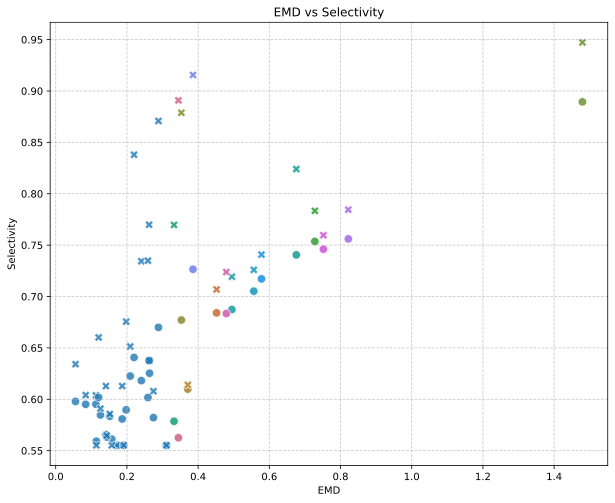

In [ ]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=metrics_df,
    x="EMD",
    y="Selectivity",
    # hue="Receptor Pair",
    style="Valency",
    s=70,
    legend=False,
    alpha=0.8,
)

sns.scatterplot(
    data=metrics_df_emd_filtered,
    x="EMD",
    y="Selectivity",
    hue="Receptor Pair",
    style="Valency",
    s=70,
    legend=False,
    alpha=0.8,
)

# Add labels for top 5 EMD receptors
# for receptor in top_emd_receptors:
#     receptor_data = metrics_df_emd_filtered[metrics_df_emd_filtered["Receptor Pair"] == receptor]
#     for _, row in receptor_data.iterrows():
#         plt.annotate(receptor, (row["EMD"], row["Selectivity"]), 
#                     xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# Add labels for top 5 selectivity receptors
# for valency in ["Valency 2", "Valency 4"]:
#     for receptor in top_selectivity_receptors[valency]:
#         if receptor not in top_emd_receptors:  # Avoid duplicate labels
#             receptor_data = metrics_df[(metrics_df["Receptor Pair"] == receptor) & 
#                                      (metrics_df["Valency"] == valency)].dropna(subset=["Selectivity"])
#             if not receptor_data.empty:
#                 row = receptor_data.iloc[0]
#                 plt.annotate(receptor, (row["EMD"], row["Selectivity"]), 
#                            xytext=(5, -10), textcoords='offset points', fontsize=8, alpha=0.8, color='red')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("EMD")
plt.ylabel("Selectivity")
plt.title("EMD vs Selectivity")
plt.show()

In [ ]:
# Get top 5 receptors for each metric
top_kl_indices = unique_receptors_df["KL Divergence"].nlargest(5).index.tolist()
top_kl_receptors = unique_receptors_df.iloc[top_kl_indices][
    "Receptor Pair"
].tolist()

top_emd_indices = unique_receptors_df["EMD"].nlargest(5).index.tolist()
top_emd_receptors = unique_receptors_df.iloc[top_emd_indices][
    "Receptor Pair"
].tolist()

# Get top 5 selectivity receptors (combined across valencies)
top_selectivity_data = metrics_df.dropna(subset=["Selectivity"]).nlargest(5, "Selectivity")
top_selectivity_receptors = top_selectivity_data["Receptor Pair"].tolist()

# Filter dataframes for each metric's top receptors
metrics_df_kl_filtered = metrics_df[
    metrics_df["Receptor Pair"].isin(top_kl_receptors)
]
metrics_df_emd_filtered = metrics_df[
    metrics_df["Receptor Pair"].isin(top_emd_receptors)
]
metrics_df_selectivity_filtered = metrics_df[
    metrics_df["Receptor Pair"].isin(top_selectivity_receptors)
]

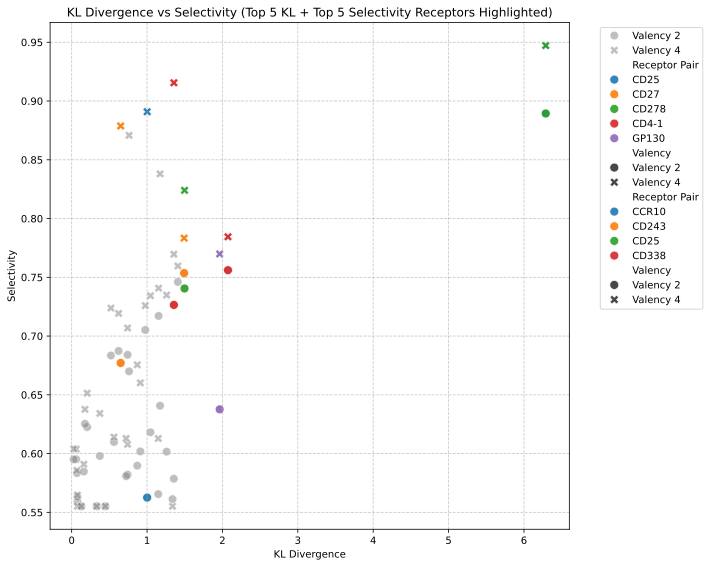

In [ ]:
plt.figure(figsize=(10, 8))

# Plot all receptors in gray
sns.scatterplot(
    data=metrics_df,
    x="KL Divergence",
    y="Selectivity",
    style="Valency",
    s=70,
    color='gray',
    alpha=0.5,
    legend=True,
)

# Plot top 5 KL receptors with colors
sns.scatterplot(
    data=metrics_df_kl_filtered,
    x="KL Divergence",
    y="Selectivity",
    hue="Receptor Pair",
    style="Valency",
    s=80,
    alpha=0.9,
)

# Plot top 5 selectivity receptors with colors
sns.scatterplot(
    data=metrics_df_selectivity_filtered,
    x="KL Divergence",
    y="Selectivity",
    hue="Receptor Pair",
    style="Valency",
    s=80,
    alpha=0.9,
)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("KL Divergence")
plt.ylabel("Selectivity")
plt.title("KL Divergence vs Selectivity (Top 5 KL + Top 5 Selectivity Receptors Highlighted)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

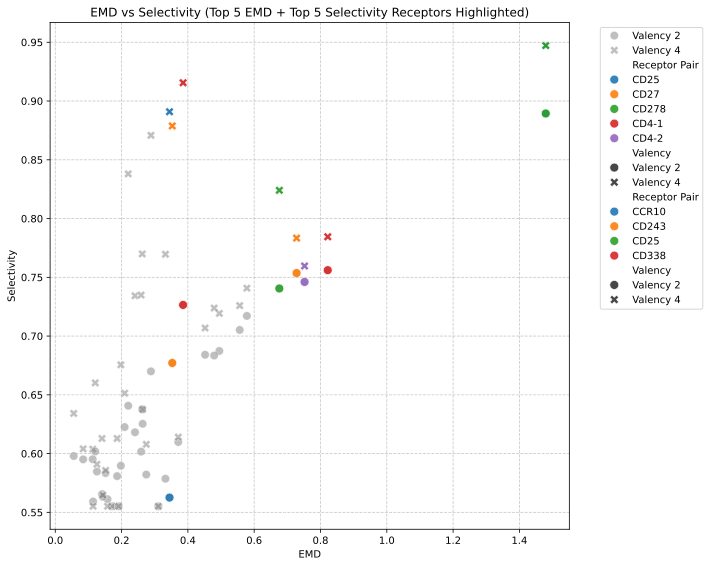

In [ ]:
plt.figure(figsize=(10, 8))

# Plot all receptors in gray
sns.scatterplot(
    data=metrics_df,
    x="EMD",
    y="Selectivity",
    style="Valency",
    s=70,
    color='gray',
    alpha=0.5,
    legend=True,
)

# Plot top 5 EMD receptors with colors
sns.scatterplot(
    data=metrics_df_emd_filtered,
    x="EMD",
    y="Selectivity",
    hue="Receptor Pair",
    style="Valency",
    s=80,
    alpha=0.9,
)

# Plot top 5 selectivity receptors with colors
sns.scatterplot(
    data=metrics_df_selectivity_filtered,
    x="EMD",
    y="Selectivity",
    hue="Receptor Pair",
    style="Valency",
    s=80,
    alpha=0.9,
)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("EMD")
plt.ylabel("Selectivity")
plt.title("EMD vs Selectivity (Top 5 EMD + Top 5 Selectivity Receptors Highlighted)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Get top 5 receptors for each metric
top_kl_indices = unique_receptors_df["KL Divergence"].nlargest(10).index.tolist()
top_kl_receptors = unique_receptors_df.iloc[top_kl_indices][
    "Receptor Pair"
].tolist()

top_emd_indices = unique_receptors_df["EMD"].nlargest(10).index.tolist()
top_emd_receptors = unique_receptors_df.iloc[top_emd_indices][
    "Receptor Pair"
].tolist()

# Get top 5 selectivity receptors (combined across valencies)
top_selectivity_data = metrics_df.dropna(subset=["Selectivity"]).nlargest(5, "Selectivity")
top_selectivity_receptors = top_selectivity_data["Receptor Pair"].tolist()

# Filter dataframes for each metric's top receptors
metrics_df_kl_filtered = metrics_df[
    metrics_df["Receptor Pair"].isin(top_kl_receptors)
]
metrics_df_emd_filtered = metrics_df[
    metrics_df["Receptor Pair"].isin(top_emd_receptors)
]
metrics_df_selectivity_filtered = metrics_df[
    metrics_df["Receptor Pair"].isin(top_selectivity_receptors)
]

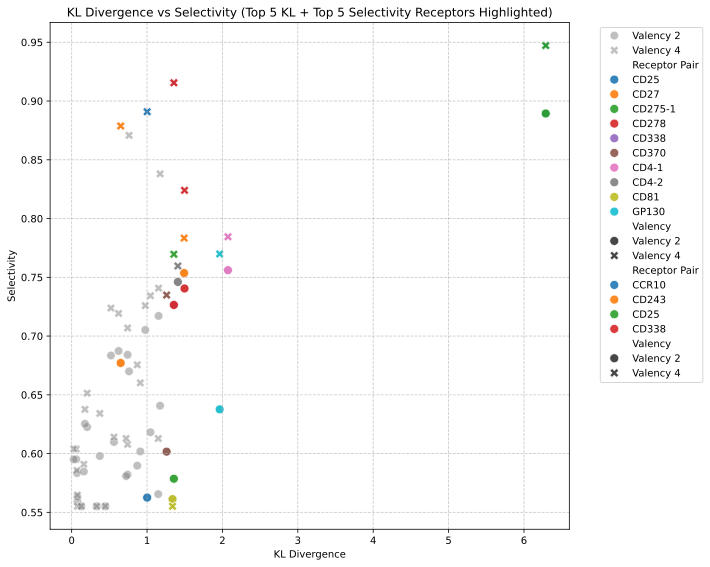

In [ ]:
plt.figure(figsize=(10, 8))

# Plot all receptors in gray
sns.scatterplot(
    data=metrics_df,
    x="KL Divergence",
    y="Selectivity",
    style="Valency",
    s=70,
    color='gray',
    alpha=0.5,
    legend=True,
)

# Plot top 5 KL receptors with colors
sns.scatterplot(
    data=metrics_df_kl_filtered,
    x="KL Divergence",
    y="Selectivity",
    hue="Receptor Pair",
    style="Valency",
    s=80,
    alpha=0.9,
)

# Plot top 5 selectivity receptors with colors
sns.scatterplot(
    data=metrics_df_selectivity_filtered,
    x="KL Divergence",
    y="Selectivity",
    hue="Receptor Pair",
    style="Valency",
    s=80,
    alpha=0.9,
)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("KL Divergence")
plt.ylabel("Selectivity")
plt.title("KL Divergence vs Selectivity (Top 5 KL + Top 5 Selectivity Receptors Highlighted)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

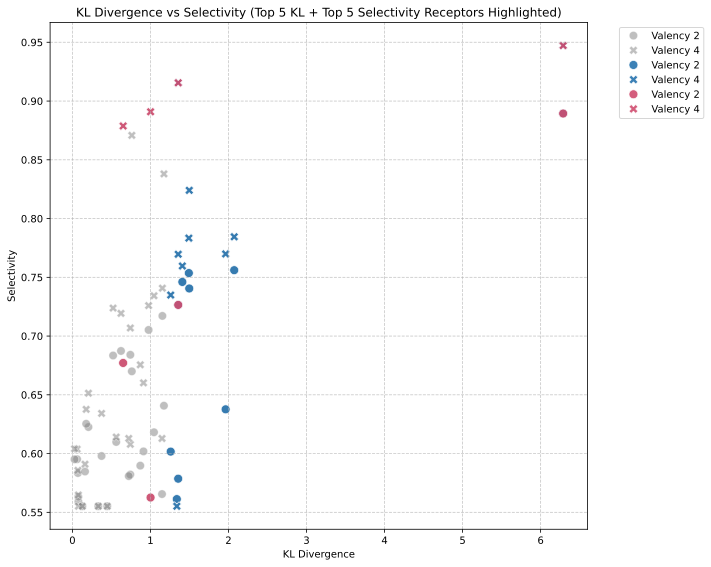

In [ ]:
plt.figure(figsize=(10, 8))

# Plot all receptors in gray
sns.scatterplot(
    data=metrics_df,
    x="KL Divergence",
    y="Selectivity",
    style="Valency",
    s=70,
    color='gray',
    alpha=0.5,
    legend=True,
)

# Plot top 5 KL receptors with colors
sns.scatterplot(
    data=metrics_df_kl_filtered,
    x="KL Divergence",
    y="Selectivity",
    style="Valency",
    color="#2774AE",
    s=80,
    alpha=0.9,
)

# Plot top 5 selectivity receptors with colors
sns.scatterplot(
    data=metrics_df_selectivity_filtered,
    x="KL Divergence",
    y="Selectivity",
    style="Valency",
    color="#CF4D6F",
    s=80,
    alpha=0.9,
)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("KL Divergence")
plt.ylabel("Selectivity")
plt.title("KL Divergence vs Selectivity (Top 5 KL + Top 5 Selectivity Receptors Highlighted)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Get top 5 receptors for each metric
top_kl_indices = unique_receptors_df["KL Divergence"].nlargest(10).index.tolist()
top_kl_receptors = unique_receptors_df.iloc[top_kl_indices][
    "Receptor Pair"
].tolist()

top_emd_indices = unique_receptors_df["EMD"].nlargest(10).index.tolist()
top_emd_receptors = unique_receptors_df.iloc[top_emd_indices][
    "Receptor Pair"
].tolist()

# Get top 5 selectivity receptors (combined across valencies)
top_selectivity_data = metrics_df.dropna(subset=["Selectivity"]).nlargest(10, "Selectivity")
top_selectivity_receptors = top_selectivity_data["Receptor Pair"].tolist()

# Filter dataframes for each metric's top receptors
metrics_df_kl_filtered = metrics_df[
    metrics_df["Receptor Pair"].isin(top_kl_receptors)
]
metrics_df_emd_filtered = metrics_df[
    metrics_df["Receptor Pair"].isin(top_emd_receptors)
]
metrics_df_selectivity_filtered = metrics_df[
    metrics_df["Receptor Pair"].isin(top_selectivity_receptors)
]

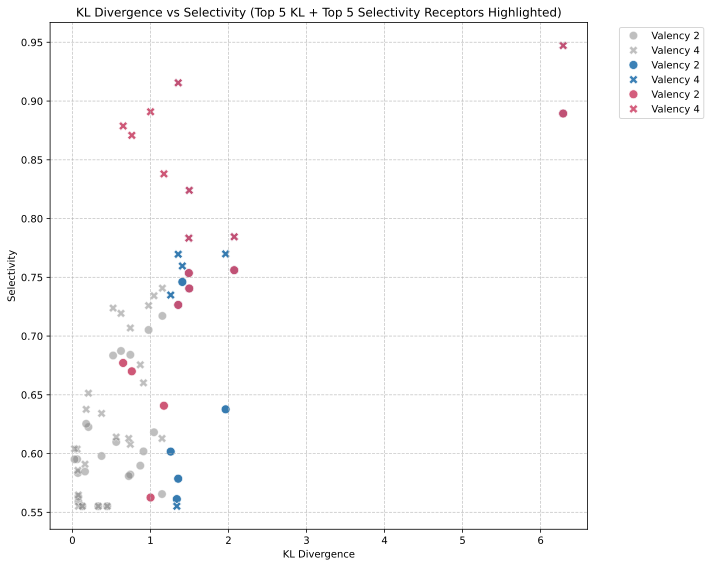

In [ ]:
plt.figure(figsize=(10, 8))

# Plot all receptors in gray
sns.scatterplot(
    data=metrics_df,
    x="KL Divergence",
    y="Selectivity",
    style="Valency",
    s=70,
    color='gray',
    alpha=0.5,
    legend=True,
)

# Plot top 5 KL receptors with colors
sns.scatterplot(
    data=metrics_df_kl_filtered,
    x="KL Divergence",
    y="Selectivity",
    style="Valency",
    color="#2774AE",
    s=80,
    alpha=0.9,
)

# Plot top 5 selectivity receptors with colors
sns.scatterplot(
    data=metrics_df_selectivity_filtered,
    x="KL Divergence",
    y="Selectivity",
    style="Valency",
    color="#CF4D6F",
    s=80,
    alpha=0.9,
)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("KL Divergence")
plt.ylabel("Selectivity")
plt.title("KL Divergence vs Selectivity (Top 5 KL + Top 5 Selectivity Receptors Highlighted)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Get top 5 receptors for each metric
top_kl_indices = unique_receptors_df["KL Divergence"].nlargest(10).index.tolist()
top_kl_receptors = unique_receptors_df.iloc[top_kl_indices][
    "Receptor Pair"
].tolist()

top_emd_indices = unique_receptors_df["EMD"].nlargest(10).index.tolist()
top_emd_receptors = unique_receptors_df.iloc[top_emd_indices][
    "Receptor Pair"
].tolist()

# Get top 5 selectivity receptors (combined across valencies)
top_selectivity_data = metrics_df.dropna(subset=["Selectivity"]).nlargest(5, "Selectivity")
top_selectivity_receptors = top_selectivity_data["Receptor Pair"].tolist()

# Create categories for KL plot
kl_both = set(top_kl_receptors).intersection(set(top_selectivity_receptors))
kl_only = set(top_kl_receptors) - set(top_selectivity_receptors)
selectivity_only_kl = set(top_selectivity_receptors) - set(top_kl_receptors)

# Create categories for EMD plot
emd_both = set(top_emd_receptors).intersection(set(top_selectivity_receptors))
emd_only = set(top_emd_receptors) - set(top_selectivity_receptors)
selectivity_only_emd = set(top_selectivity_receptors) - set(top_emd_receptors)

# Filter dataframes for KL plot categories
metrics_df_kl_both = metrics_df[metrics_df["Receptor Pair"].isin(kl_both)]
metrics_df_kl_only = metrics_df[metrics_df["Receptor Pair"].isin(kl_only)]
metrics_df_selectivity_only_kl = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_kl)]

# Filter dataframes for EMD plot categories
metrics_df_emd_both = metrics_df[metrics_df["Receptor Pair"].isin(emd_both)]
metrics_df_emd_only = metrics_df[metrics_df["Receptor Pair"].isin(emd_only)]
metrics_df_selectivity_only_emd = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_emd)]

TypeError: seaborn.utils._scatter_legend_artist() got multiple values for keyword argument 'label'

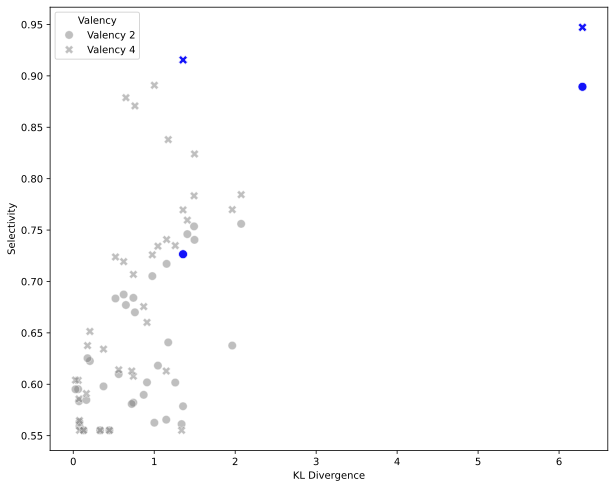

In [ ]:
plt.figure(figsize=(10, 8))

# Plot all receptors in gray
sns.scatterplot(
    data=metrics_df,
    x="KL Divergence",
    y="Selectivity",
    style="Valency",
    s=70,
    color='gray',
    alpha=0.5,
    legend=True,
)

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    sns.scatterplot(
        data=metrics_df_kl_both,
        x="KL Divergence",
        y="Selectivity",
        style="Valency",
        color="blue",
        s=80,
        alpha=0.9,
        label="Both KL & Selectivity"
    )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    sns.scatterplot(
        data=metrics_df_kl_only,
        x="KL Divergence",
        y="Selectivity",
        style="Valency",
        color="red",
        s=80,
        alpha=0.9,
        label="KL Only"
    )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    sns.scatterplot(
        data=metrics_df_selectivity_only_kl,
        x="KL Divergence",
        y="Selectivity",
        style="Valency",
        color="gold",
        s=80,
        alpha=0.9,
        label="Selectivity Only"
    )

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("KL Divergence")
plt.ylabel("Selectivity")
plt.title("KL Divergence vs Selectivity (Top 5 Receptors by Category)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Get top 5 receptors for each metric
top_kl_indices = unique_receptors_df["KL Divergence"].nlargest(10).index.tolist()
top_kl_receptors = unique_receptors_df.iloc[top_kl_indices][
    "Receptor Pair"
].tolist()

top_emd_indices = unique_receptors_df["EMD"].nlargest(10).index.tolist()
top_emd_receptors = unique_receptors_df.iloc[top_emd_indices][
    "Receptor Pair"
].tolist()

# Get top 5 selectivity receptors (combined across valencies)
top_selectivity_data = metrics_df.dropna(subset=["Selectivity"]).nlargest(5, "Selectivity")
top_selectivity_receptors = top_selectivity_data["Receptor Pair"].tolist()

# Create categories for KL plot
kl_both = set(top_kl_receptors).intersection(set(top_selectivity_receptors))
kl_only = set(top_kl_receptors) - set(top_selectivity_receptors)
selectivity_only_kl = set(top_selectivity_receptors) - set(top_kl_receptors)

# Create categories for EMD plot
emd_both = set(top_emd_receptors).intersection(set(top_selectivity_receptors))
emd_only = set(top_emd_receptors) - set(top_selectivity_receptors)
selectivity_only_emd = set(top_selectivity_receptors) - set(top_emd_receptors)

# Filter dataframes for KL plot categories
metrics_df_kl_both = metrics_df[metrics_df["Receptor Pair"].isin(kl_both)]
metrics_df_kl_only = metrics_df[metrics_df["Receptor Pair"].isin(kl_only)]
metrics_df_selectivity_only_kl = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_kl)]

# Filter dataframes for EMD plot categories
metrics_df_emd_both = metrics_df[metrics_df["Receptor Pair"].isin(emd_both)]
metrics_df_emd_only = metrics_df[metrics_df["Receptor Pair"].isin(emd_only)]
metrics_df_selectivity_only_emd = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_emd)]

TypeError: seaborn.utils._scatter_legend_artist() got multiple values for keyword argument 'label'

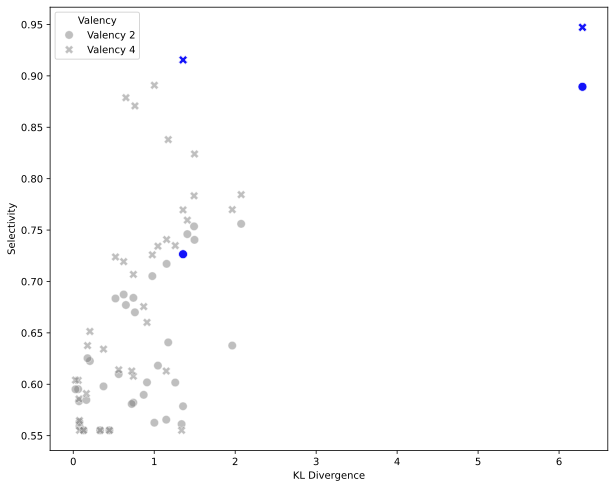

In [ ]:
plt.figure(figsize=(10, 8))

# Plot all receptors in gray
sns.scatterplot(
    data=metrics_df,
    x="KL Divergence",
    y="Selectivity",
    style="Valency",
    s=70,
    color='gray',
    alpha=0.5,
    legend=True,
)

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    sns.scatterplot(
        data=metrics_df_kl_both,
        x="KL Divergence",
        y="Selectivity",
        style="Valency",
        color="blue",
        s=80,
        alpha=0.9,
        label="Both KL & Selectivity"
    )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    sns.scatterplot(
        data=metrics_df_kl_only,
        x="KL Divergence",
        y="Selectivity",
        style="Valency",
        color="red",
        s=80,
        alpha=0.9,
        label="KL Only"
    )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    sns.scatterplot(
        data=metrics_df_selectivity_only_kl,
        x="KL Divergence",
        y="Selectivity",
        style="Valency",
        color="gold",
        s=80,
        alpha=0.9,
        label="Selectivity Only"
    )

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("KL Divergence")
plt.ylabel("Selectivity")
plt.title("KL Divergence vs Selectivity (Top 5 Receptors by Category)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Get top 5 receptors for each metric
top_kl_indices = unique_receptors_df["KL Divergence"].nlargest(10).index.tolist()
top_kl_receptors = unique_receptors_df.iloc[top_kl_indices][
    "Receptor Pair"
].tolist()

top_emd_indices = unique_receptors_df["EMD"].nlargest(10).index.tolist()
top_emd_receptors = unique_receptors_df.iloc[top_emd_indices][
    "Receptor Pair"
].tolist()

# Get top 5 selectivity receptors (combined across valencies)
top_selectivity_data = metrics_df.dropna(subset=["Selectivity"]).nlargest(5, "Selectivity")
top_selectivity_receptors = top_selectivity_data["Receptor Pair"].tolist()

# Create categories for KL plot
kl_both = set(top_kl_receptors).intersection(set(top_selectivity_receptors))
kl_only = set(top_kl_receptors) - set(top_selectivity_receptors)
selectivity_only_kl = set(top_selectivity_receptors) - set(top_kl_receptors)

# Create categories for EMD plot
emd_both = set(top_emd_receptors).intersection(set(top_selectivity_receptors))
emd_only = set(top_emd_receptors) - set(top_selectivity_receptors)
selectivity_only_emd = set(top_selectivity_receptors) - set(top_emd_receptors)

# Filter dataframes for KL plot categories
metrics_df_kl_both = metrics_df[metrics_df["Receptor Pair"].isin(kl_both)]
metrics_df_kl_only = metrics_df[metrics_df["Receptor Pair"].isin(kl_only)]
metrics_df_selectivity_only_kl = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_kl)]

# Filter dataframes for EMD plot categories
metrics_df_emd_both = metrics_df[metrics_df["Receptor Pair"].isin(emd_both)]
metrics_df_emd_only = metrics_df[metrics_df["Receptor Pair"].isin(emd_only)]
metrics_df_selectivity_only_emd = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_emd)]

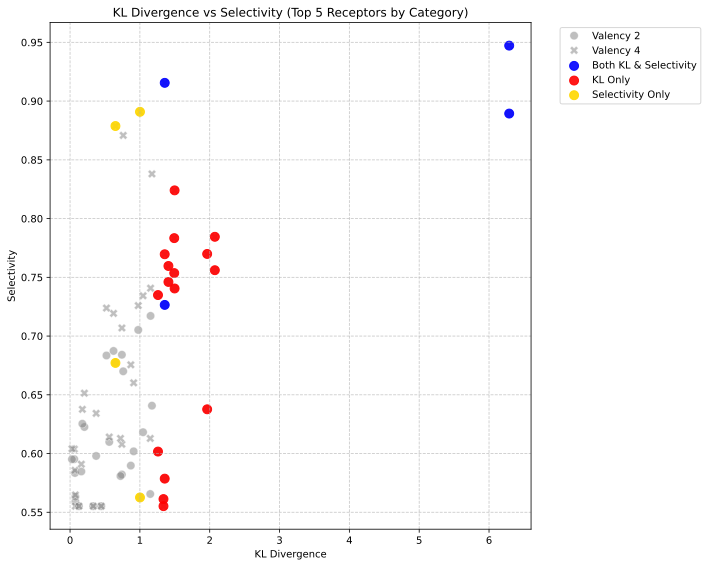

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
sns.scatterplot(
    data=metrics_df,
    x="KL Divergence",
    y="Selectivity",
    style="Valency",
    s=70,
    color='gray',
    alpha=0.5,
    ax=ax
)

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    ax.scatter(
        metrics_df_kl_both["KL Divergence"],
        metrics_df_kl_both["Selectivity"],
        color="blue",
        s=80,
        alpha=0.9,
        label="Both KL & Selectivity"
    )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    ax.scatter(
        metrics_df_kl_only["KL Divergence"],
        metrics_df_kl_only["Selectivity"],
        color="red",
        s=80,
        alpha=0.9,
        label="KL Only"
    )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    ax.scatter(
        metrics_df_selectivity_only_kl["KL Divergence"],
        metrics_df_selectivity_only_kl["Selectivity"],
        color="gold",
        s=80,
        alpha=0.9,
        label="Selectivity Only"
    )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL Divergence")
ax.set_ylabel("Selectivity")
ax.set_title("KL Divergence vs Selectivity (Top 5 Receptors by Category)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

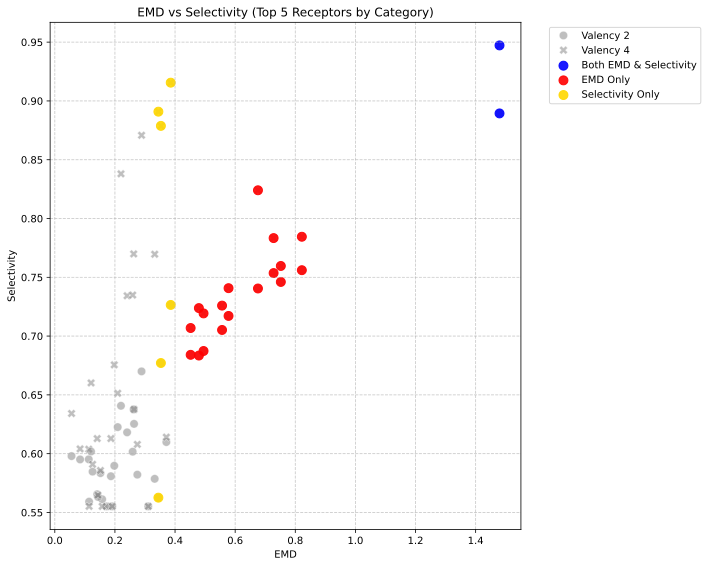

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
sns.scatterplot(
    data=metrics_df,
    x="EMD",
    y="Selectivity",
    style="Valency",
    s=70,
    color='gray',
    alpha=0.5,
    ax=ax
)

# Plot receptors identified by both EMD and selectivity (blue)
if len(metrics_df_emd_both) > 0:
    ax.scatter(
        metrics_df_emd_both["EMD"],
        metrics_df_emd_both["Selectivity"],
        color="blue",
        s=80,
        alpha=0.9,
        label="Both EMD & Selectivity"
    )

# Plot receptors identified only by EMD (red)
if len(metrics_df_emd_only) > 0:
    ax.scatter(
        metrics_df_emd_only["EMD"],
        metrics_df_emd_only["Selectivity"],
        color="red",
        s=80,
        alpha=0.9,
        label="EMD Only"
    )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_emd) > 0:
    ax.scatter(
        metrics_df_selectivity_only_emd["EMD"],
        metrics_df_selectivity_only_emd["Selectivity"],
        color="gold",
        s=80,
        alpha=0.9,
        label="Selectivity Only"
    )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("EMD")
ax.set_ylabel("Selectivity")
ax.set_title("EMD vs Selectivity (Top 5 Receptors by Category)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

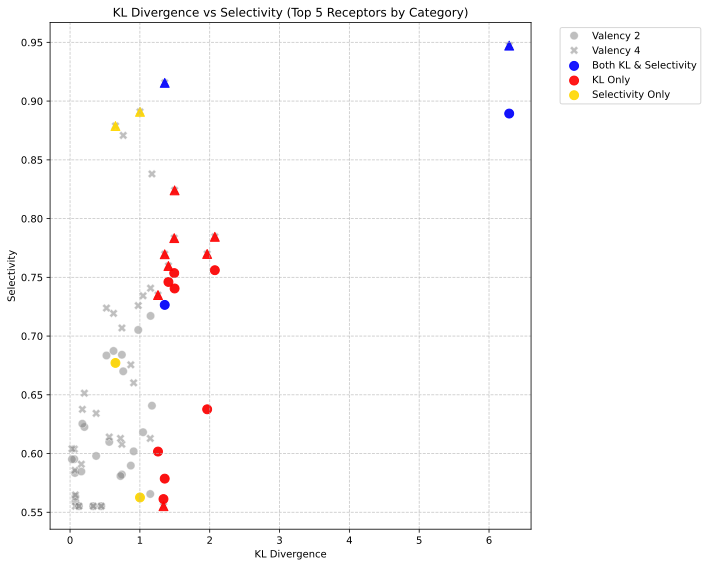

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
sns.scatterplot(
    data=metrics_df,
    x="KL Divergence",
    y="Selectivity",
    style="Valency",
    s=70,
    color='gray',
    alpha=0.5,
    ax=ax
)

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else '^'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="blue",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else '^'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="red",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else '^'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="gold",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL Divergence")
ax.set_ylabel("Selectivity")
ax.set_title("KL Divergence vs Selectivity (Top 5 Receptors by Category)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Get top 5 receptors for each metric
top_kl_indices = unique_receptors_df["KL Divergence"].nlargest(10).index.tolist()
top_kl_receptors = unique_receptors_df.iloc[top_kl_indices][
    "Receptor Pair"
].tolist()

top_emd_indices = unique_receptors_df["EMD"].nlargest(10).index.tolist()
top_emd_receptors = unique_receptors_df.iloc[top_emd_indices][
    "Receptor Pair"
].tolist()

# Get top 5 selectivity receptors (combined across valencies)
top_selectivity_data = metrics_df.dropna(subset=["Selectivity"]).nlargest(10, "Selectivity")
top_selectivity_receptors = top_selectivity_data["Receptor Pair"].tolist()

# Create categories for KL plot
kl_both = set(top_kl_receptors).intersection(set(top_selectivity_receptors))
kl_only = set(top_kl_receptors) - set(top_selectivity_receptors)
selectivity_only_kl = set(top_selectivity_receptors) - set(top_kl_receptors)

# Create categories for EMD plot
emd_both = set(top_emd_receptors).intersection(set(top_selectivity_receptors))
emd_only = set(top_emd_receptors) - set(top_selectivity_receptors)
selectivity_only_emd = set(top_selectivity_receptors) - set(top_emd_receptors)

# Filter dataframes for KL plot categories
metrics_df_kl_both = metrics_df[metrics_df["Receptor Pair"].isin(kl_both)]
metrics_df_kl_only = metrics_df[metrics_df["Receptor Pair"].isin(kl_only)]
metrics_df_selectivity_only_kl = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_kl)]

# Filter dataframes for EMD plot categories
metrics_df_emd_both = metrics_df[metrics_df["Receptor Pair"].isin(emd_both)]
metrics_df_emd_only = metrics_df[metrics_df["Receptor Pair"].isin(emd_only)]
metrics_df_selectivity_only_emd = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_emd)]

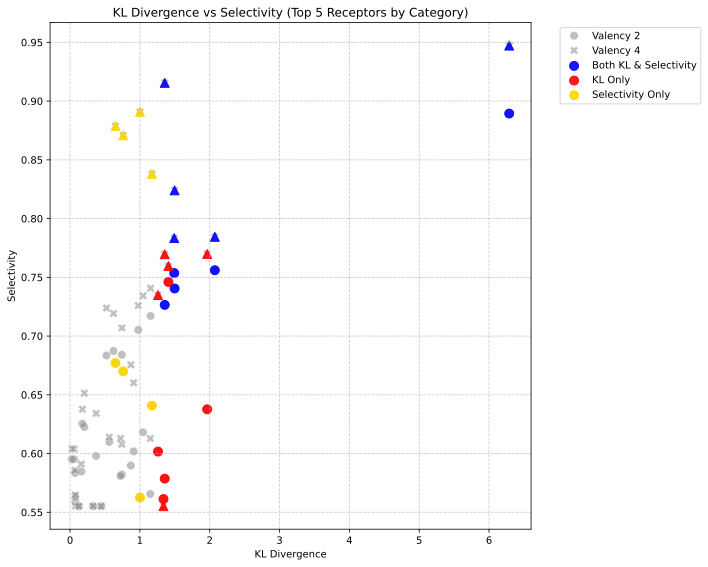

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
sns.scatterplot(
    data=metrics_df,
    x="KL Divergence",
    y="Selectivity",
    style="Valency",
    s=70,
    color='gray',
    alpha=0.5,
    ax=ax
)

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else '^'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="blue",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else '^'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="red",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else '^'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="gold",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL Divergence")
ax.set_ylabel("Selectivity")
ax.set_title("KL Divergence vs Selectivity (Top 5 Receptors by Category)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Get top 5 receptors for each metric (each receptor counted once)
top_kl_indices = unique_receptors_df["KL Divergence"].nlargest(5).index.tolist()
top_kl_receptors = unique_receptors_df.iloc[top_kl_indices][
    "Receptor Pair"
].tolist()

top_emd_indices = unique_receptors_df["EMD"].nlargest(5).index.tolist()
top_emd_receptors = unique_receptors_df.iloc[top_emd_indices][
    "Receptor Pair"
].tolist()

# Get top 5 selectivity receptors (taking best selectivity per receptor across valencies)
selectivity_per_receptor = metrics_df.dropna(subset=["Selectivity"]).groupby("Receptor Pair")["Selectivity"].max().reset_index()
top_selectivity_data = selectivity_per_receptor.nlargest(5, "Selectivity")
top_selectivity_receptors = top_selectivity_data["Receptor Pair"].tolist()

# Create categories for KL plot
kl_both = set(top_kl_receptors).intersection(set(top_selectivity_receptors))
kl_only = set(top_kl_receptors) - set(top_selectivity_receptors)
selectivity_only_kl = set(top_selectivity_receptors) - set(top_kl_receptors)

# Create categories for EMD plot
emd_both = set(top_emd_receptors).intersection(set(top_selectivity_receptors))
emd_only = set(top_emd_receptors) - set(top_selectivity_receptors)
selectivity_only_emd = set(top_selectivity_receptors) - set(top_emd_receptors)

# Filter dataframes for KL plot categories
metrics_df_kl_both = metrics_df[metrics_df["Receptor Pair"].isin(kl_both)]
metrics_df_kl_only = metrics_df[metrics_df["Receptor Pair"].isin(kl_only)]
metrics_df_selectivity_only_kl = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_kl)]

# Filter dataframes for EMD plot categories
metrics_df_emd_both = metrics_df[metrics_df["Receptor Pair"].isin(emd_both)]
metrics_df_emd_only = metrics_df[metrics_df["Receptor Pair"].isin(emd_only)]
metrics_df_selectivity_only_emd = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_emd)]

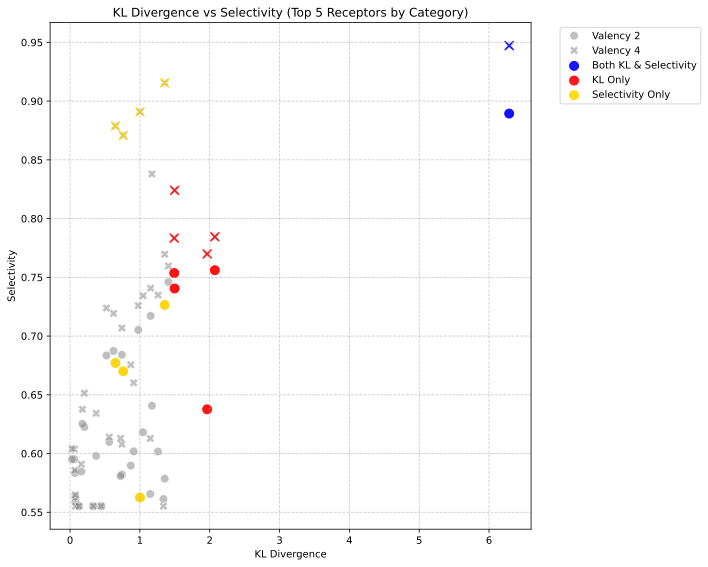

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
sns.scatterplot(
    data=metrics_df,
    x="KL Divergence",
    y="Selectivity",
    style="Valency",
    s=70,
    color='gray',
    alpha=0.5,
    ax=ax
)

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'x'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="blue",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'x'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="red",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'x'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="gold",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL Divergence")
ax.set_ylabel("Selectivity")
ax.set_title("KL Divergence vs Selectivity (Top 5 Receptors by Category)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

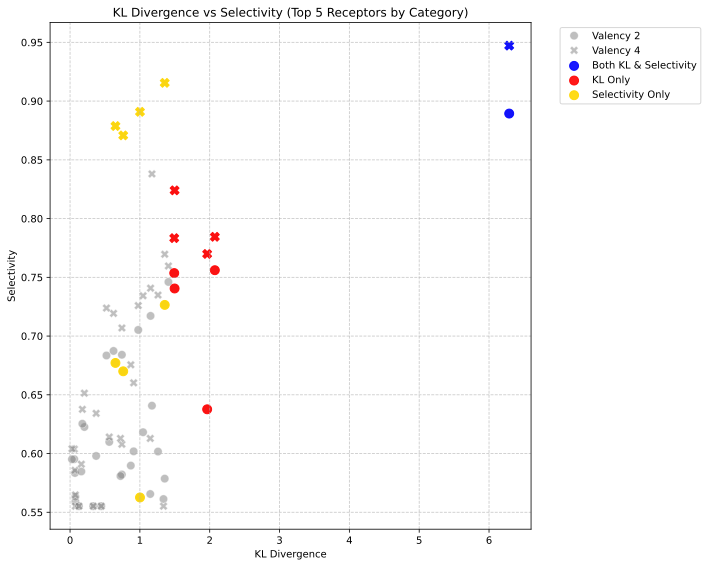

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
sns.scatterplot(
    data=metrics_df,
    x="KL Divergence",
    y="Selectivity",
    style="Valency",
    s=70,
    color='gray',
    alpha=0.5,
    ax=ax
)

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="blue",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="red",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="gold",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL Divergence")
ax.set_ylabel("Selectivity")
ax.set_title("KL Divergence vs Selectivity (Top 5 Receptors by Category)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

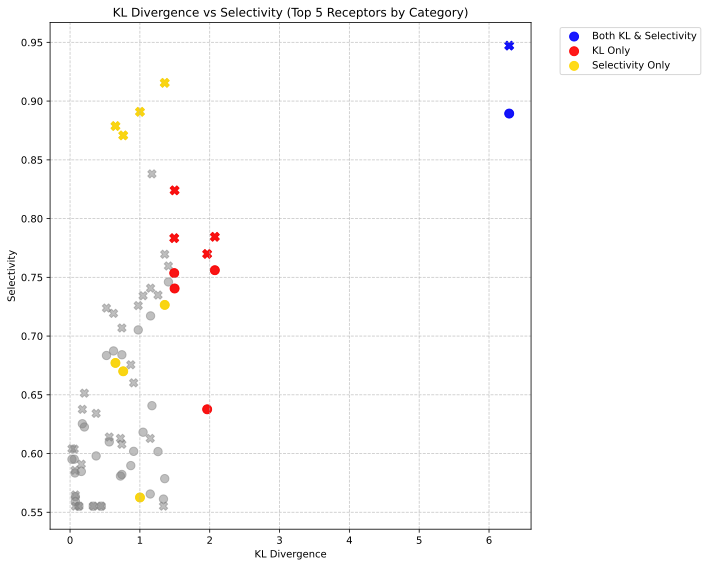

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
# Plot all receptors in gray with specific markers by valency
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["KL Divergence"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="blue",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="red",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="gold",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL Divergence")
ax.set_ylabel("Selectivity")
ax.set_title("KL Divergence vs Selectivity (Top 5 Receptors by Category)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Get top 10 receptors for each metric (each receptor counted once)
top_kl_indices = unique_receptors_df["KL Divergence"].nlargest(10).index.tolist()
top_kl_receptors = unique_receptors_df.iloc[top_kl_indices][
    "Receptor Pair"
].tolist()

top_emd_indices = unique_receptors_df["EMD"].nlargest(10).index.tolist()
top_emd_receptors = unique_receptors_df.iloc[top_emd_indices][
    "Receptor Pair"
].tolist()

# Get top 10 selectivity receptors (taking best selectivity per receptor across valencies)
selectivity_per_receptor = metrics_df.dropna(subset=["Selectivity"]).groupby("Receptor Pair")["Selectivity"].max().reset_index()
top_selectivity_data = selectivity_per_receptor.nlargest(10, "Selectivity")
top_selectivity_receptors = top_selectivity_data["Receptor Pair"].tolist()

# Create categories for KL plot
kl_both = set(top_kl_receptors).intersection(set(top_selectivity_receptors))
kl_only = set(top_kl_receptors) - set(top_selectivity_receptors)
selectivity_only_kl = set(top_selectivity_receptors) - set(top_kl_receptors)

# Create categories for EMD plot
emd_both = set(top_emd_receptors).intersection(set(top_selectivity_receptors))
emd_only = set(top_emd_receptors) - set(top_selectivity_receptors)
selectivity_only_emd = set(top_selectivity_receptors) - set(top_emd_receptors)

# Filter dataframes for KL plot categories
metrics_df_kl_both = metrics_df[metrics_df["Receptor Pair"].isin(kl_both)]
metrics_df_kl_only = metrics_df[metrics_df["Receptor Pair"].isin(kl_only)]
metrics_df_selectivity_only_kl = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_kl)]

# Filter dataframes for EMD plot categories
metrics_df_emd_both = metrics_df[metrics_df["Receptor Pair"].isin(emd_both)]
metrics_df_emd_only = metrics_df[metrics_df["Receptor Pair"].isin(emd_only)]
metrics_df_selectivity_only_emd = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_emd)]

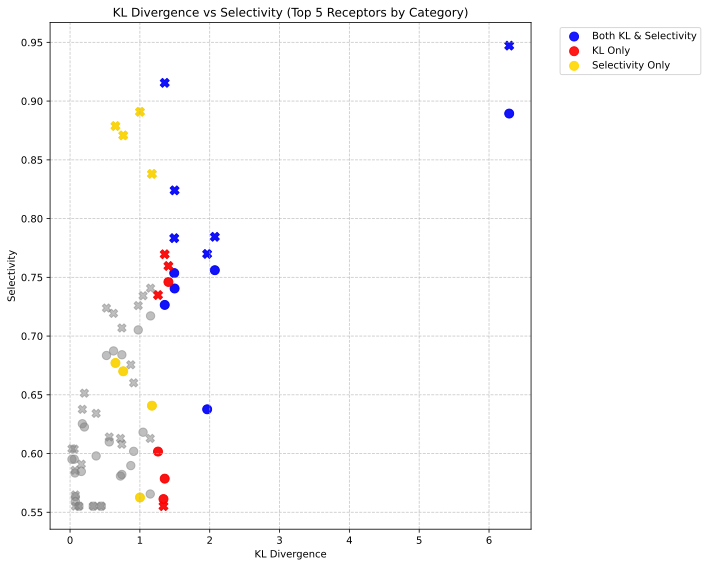

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
# Plot all receptors in gray with specific markers by valency
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["KL Divergence"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="blue",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="red",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="gold",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL Divergence")
ax.set_ylabel("Selectivity")
ax.set_title("KL Divergence vs Selectivity (Top 5 Receptors by Category)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Get top 7 receptors for each metric (each receptor counted once)
top_kl_indices = unique_receptors_df["KL Divergence"].nlargest(7).index.tolist()
top_kl_receptors = unique_receptors_df.iloc[top_kl_indices][
    "Receptor Pair"
].tolist()

top_emd_indices = unique_receptors_df["EMD"].nlargest(7).index.tolist()
top_emd_receptors = unique_receptors_df.iloc[top_emd_indices][
    "Receptor Pair"
].tolist()

# Get top 7 selectivity receptors (taking best selectivity per receptor across valencies)
selectivity_per_receptor = metrics_df.dropna(subset=["Selectivity"]).groupby("Receptor Pair")["Selectivity"].max().reset_index()
top_selectivity_data = selectivity_per_receptor.nlargest(7, "Selectivity")
top_selectivity_receptors = top_selectivity_data["Receptor Pair"].tolist()

# Create categories for KL plot
kl_both = set(top_kl_receptors).intersection(set(top_selectivity_receptors))
kl_only = set(top_kl_receptors) - set(top_selectivity_receptors)
selectivity_only_kl = set(top_selectivity_receptors) - set(top_kl_receptors)

# Create categories for EMD plot
emd_both = set(top_emd_receptors).intersection(set(top_selectivity_receptors))
emd_only = set(top_emd_receptors) - set(top_selectivity_receptors)
selectivity_only_emd = set(top_selectivity_receptors) - set(top_emd_receptors)

# Filter dataframes for KL plot categories
metrics_df_kl_both = metrics_df[metrics_df["Receptor Pair"].isin(kl_both)]
metrics_df_kl_only = metrics_df[metrics_df["Receptor Pair"].isin(kl_only)]
metrics_df_selectivity_only_kl = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_kl)]

# Filter dataframes for EMD plot categories
metrics_df_emd_both = metrics_df[metrics_df["Receptor Pair"].isin(emd_both)]
metrics_df_emd_only = metrics_df[metrics_df["Receptor Pair"].isin(emd_only)]
metrics_df_selectivity_only_emd = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_emd)]

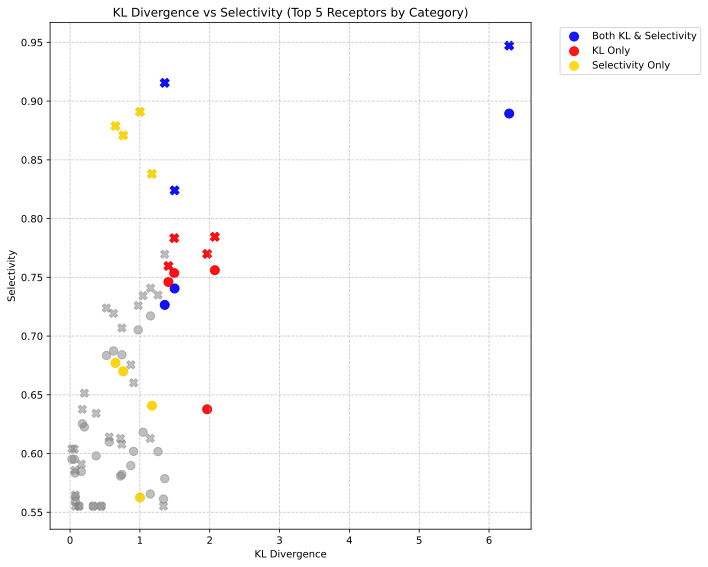

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
# Plot all receptors in gray with specific markers by valency
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["KL Divergence"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="blue",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="red",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="gold",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL Divergence")
ax.set_ylabel("Selectivity")
ax.set_title("KL Divergence vs Selectivity (Top 5 Receptors by Category)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

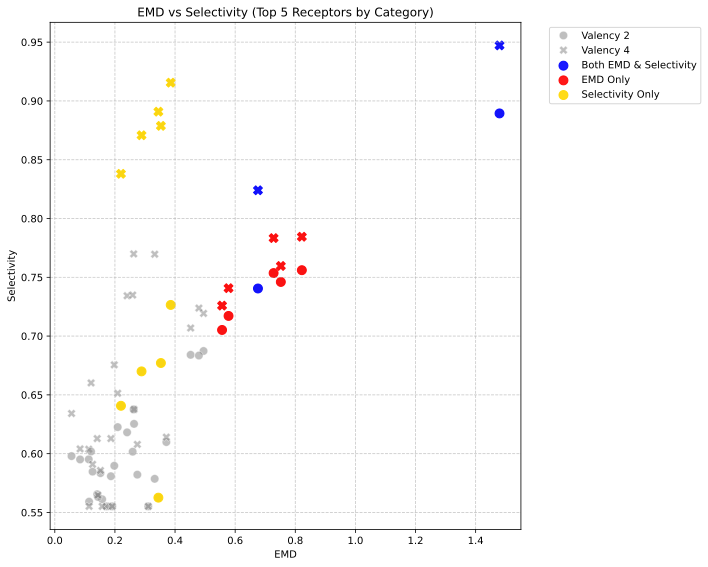

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
sns.scatterplot(
    data=metrics_df,
    x="EMD",
    y="Selectivity",
    style="Valency",
    s=70,
    color='gray',
    alpha=0.5,
    ax=ax
)

# Plot receptors identified by both EMD and selectivity (blue)
if len(metrics_df_emd_both) > 0:
    for valency in metrics_df_emd_both["Valency"].unique():
        subset = metrics_df_emd_both[metrics_df_emd_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="blue",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both EMD & Selectivity" if valency == metrics_df_emd_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by EMD (red)
if len(metrics_df_emd_only) > 0:
    for valency in metrics_df_emd_only["Valency"].unique():
        subset = metrics_df_emd_only[metrics_df_emd_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="red",
            s=80,
            alpha=0.9,
            marker=marker,
            label="EMD Only" if valency == metrics_df_emd_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_emd) > 0:
    for valency in metrics_df_selectivity_only_emd["Valency"].unique():
        subset = metrics_df_selectivity_only_emd[metrics_df_selectivity_only_emd["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="gold",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_emd["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("EMD")
ax.set_ylabel("Selectivity")
ax.set_title("EMD vs Selectivity (Top 5 Receptors by Category)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

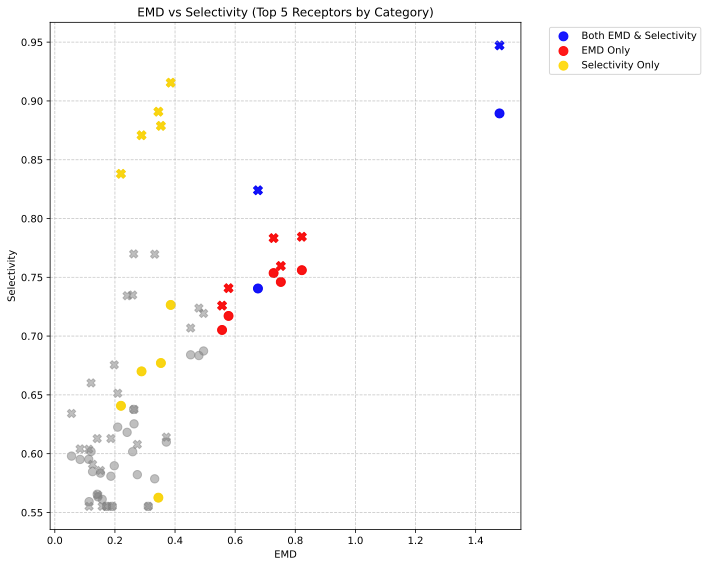

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["EMD"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both EMD and selectivity (blue)
if len(metrics_df_emd_both) > 0:
    for valency in metrics_df_emd_both["Valency"].unique():
        subset = metrics_df_emd_both[metrics_df_emd_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="blue",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both EMD & Selectivity" if valency == metrics_df_emd_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by EMD (red)
if len(metrics_df_emd_only) > 0:
    for valency in metrics_df_emd_only["Valency"].unique():
        subset = metrics_df_emd_only[metrics_df_emd_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="red",
            s=80,
            alpha=0.9,
            marker=marker,
            label="EMD Only" if valency == metrics_df_emd_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_emd) > 0:
    for valency in metrics_df_selectivity_only_emd["Valency"].unique():
        subset = metrics_df_selectivity_only_emd[metrics_df_selectivity_only_emd["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="gold",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_emd["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("EMD")
ax.set_ylabel("Selectivity")
ax.set_title("EMD vs Selectivity (Top 5 Receptors by Category)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

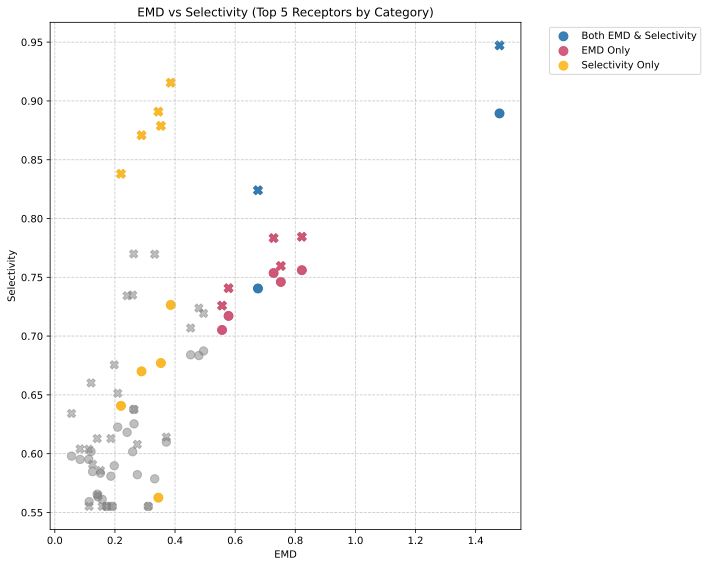

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["EMD"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both EMD and selectivity (blue)
if len(metrics_df_emd_both) > 0:
    for valency in metrics_df_emd_both["Valency"].unique():
        subset = metrics_df_emd_both[metrics_df_emd_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both EMD & Selectivity" if valency == metrics_df_emd_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by EMD (red)
if len(metrics_df_emd_only) > 0:
    for valency in metrics_df_emd_only["Valency"].unique():
        subset = metrics_df_emd_only[metrics_df_emd_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="EMD Only" if valency == metrics_df_emd_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_emd) > 0:
    for valency in metrics_df_selectivity_only_emd["Valency"].unique():
        subset = metrics_df_selectivity_only_emd[metrics_df_selectivity_only_emd["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_emd["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("EMD")
ax.set_ylabel("Selectivity")
ax.set_title("EMD vs Selectivity (Top 5 Receptors by Category)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

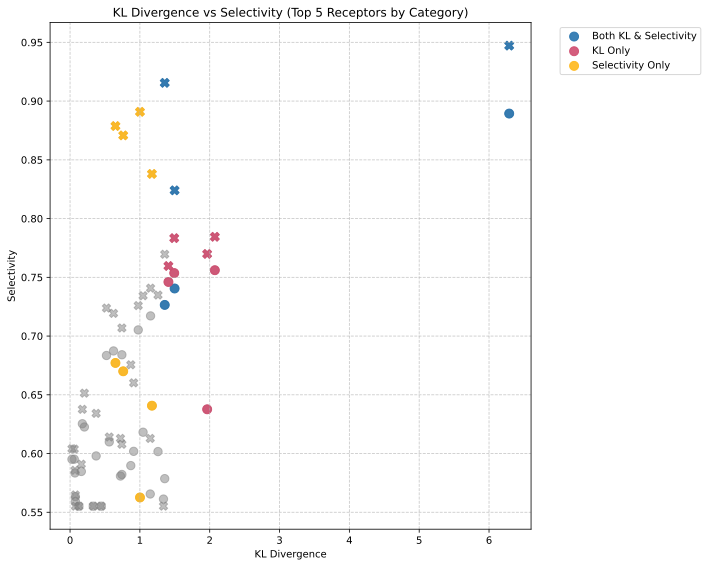

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
# Plot all receptors in gray with specific markers by valency
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["KL Divergence"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL Divergence")
ax.set_ylabel("Selectivity")
ax.set_title("KL Divergence vs Selectivity (Top 5 Receptors by Category)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

TypeError: Axis.set_ticks() missing 1 required positional argument: 'ticks'

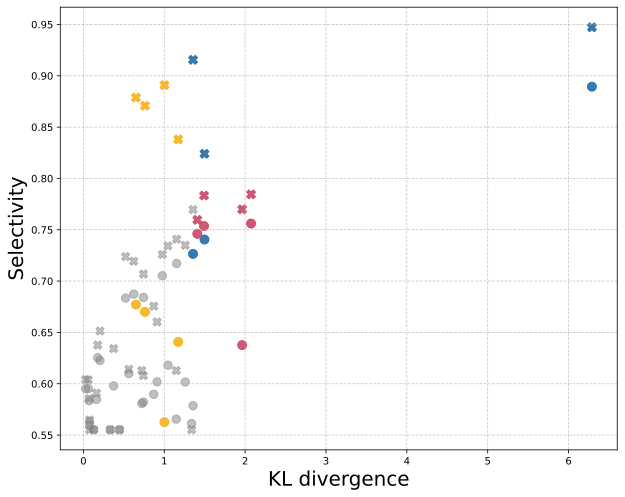

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
# Plot all receptors in gray with specific markers by valency
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["KL Divergence"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL divergence", fontsize=20)
ax.set_ylabel("Selectivity", fontsize=20)
ax.set_xticks(fontsize=20)
ax.set_yticks(fontsize=20)
ax.set_title("KL Divergence vs Selectivity (Top 5 Receptors by Category)", fontsize=24)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

AttributeError: 'Axes' object has no attribute 'xticks'

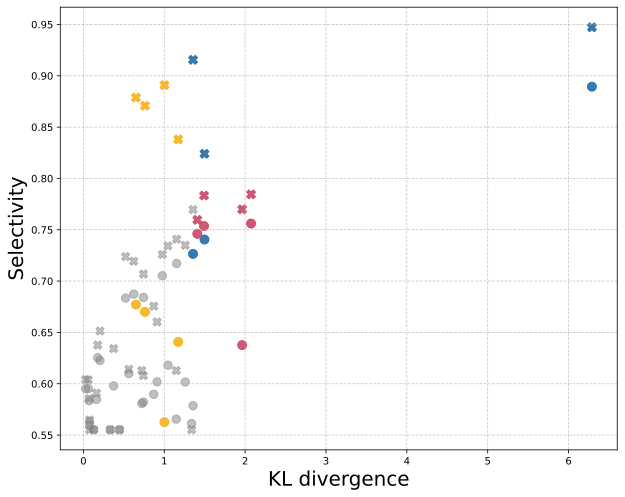

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
# Plot all receptors in gray with specific markers by valency
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["KL Divergence"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL divergence", fontsize=20)
ax.set_ylabel("Selectivity", fontsize=20)
ax.xticks(fontsize=20)
ax.set_yticks(fontsize=20)
ax.set_title("KL Divergence vs Selectivity (Top 5 Receptors by Category)", fontsize=24)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

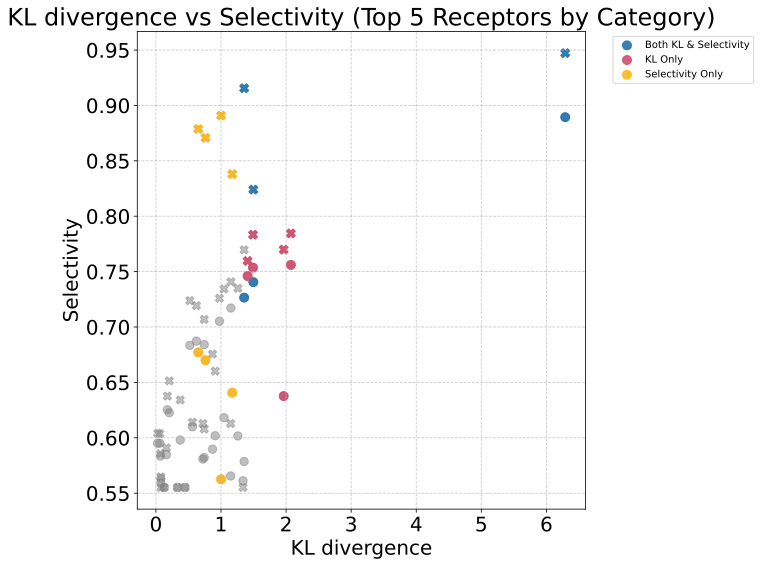

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
# Plot all receptors in gray with specific markers by valency
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["KL Divergence"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL divergence", fontsize=20)
ax.set_ylabel("Selectivity", fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_title("KL divergence vs Selectivity (Top 5 Receptors by Category)", fontsize=24)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

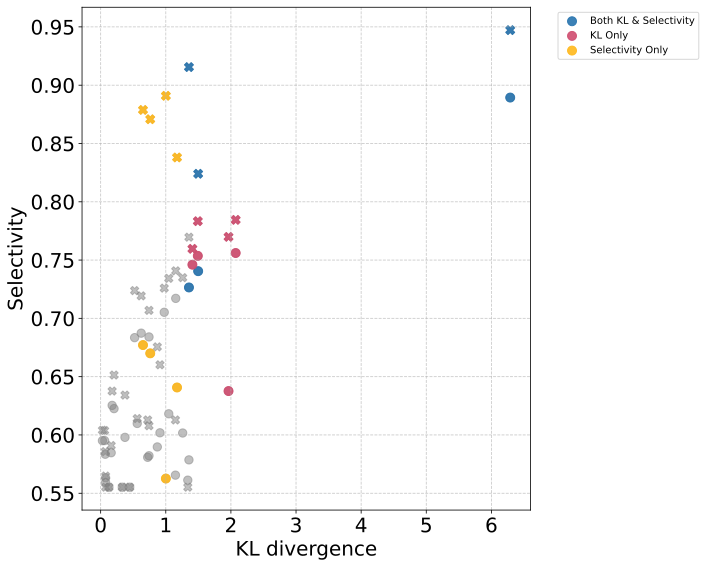

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
# Plot all receptors in gray with specific markers by valency
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["KL Divergence"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL divergence", fontsize=20)
ax.set_ylabel("Selectivity", fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

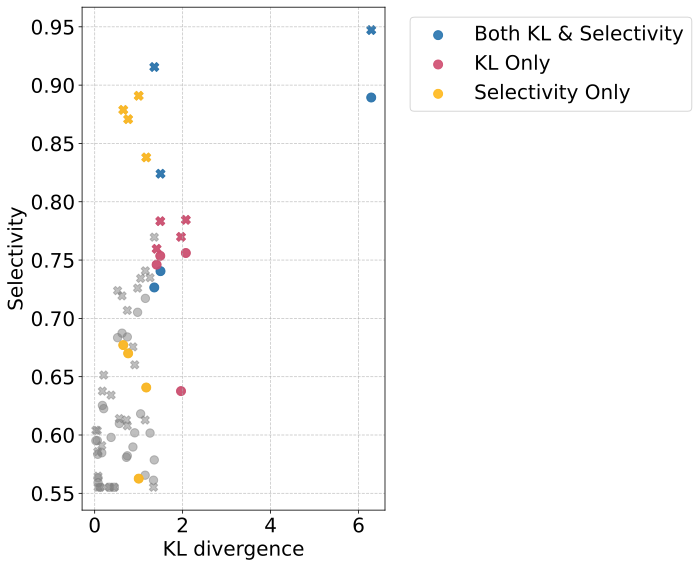

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
# Plot all receptors in gray with specific markers by valency
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["KL Divergence"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL divergence", fontsize=20)
ax.set_ylabel("Selectivity", fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.tight_layout()
plt.show()

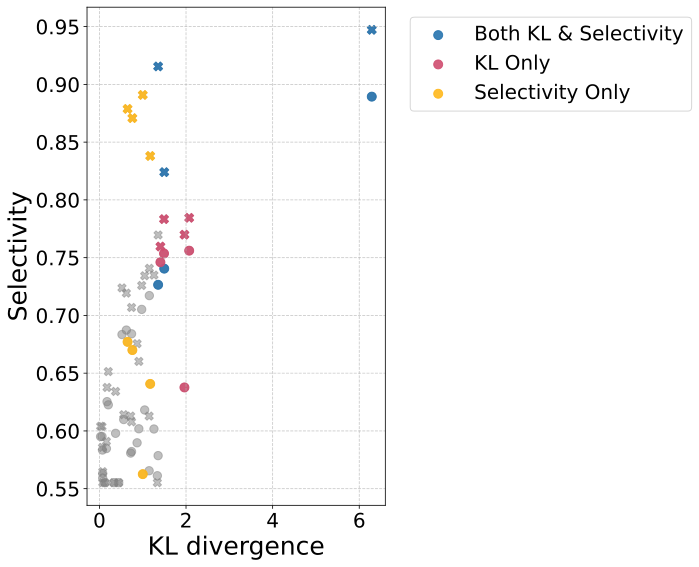

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
# Plot all receptors in gray with specific markers by valency
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["KL Divergence"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL divergence", fontsize=25)
ax.set_ylabel("Selectivity", fontsize=25)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.tight_layout()
plt.show()

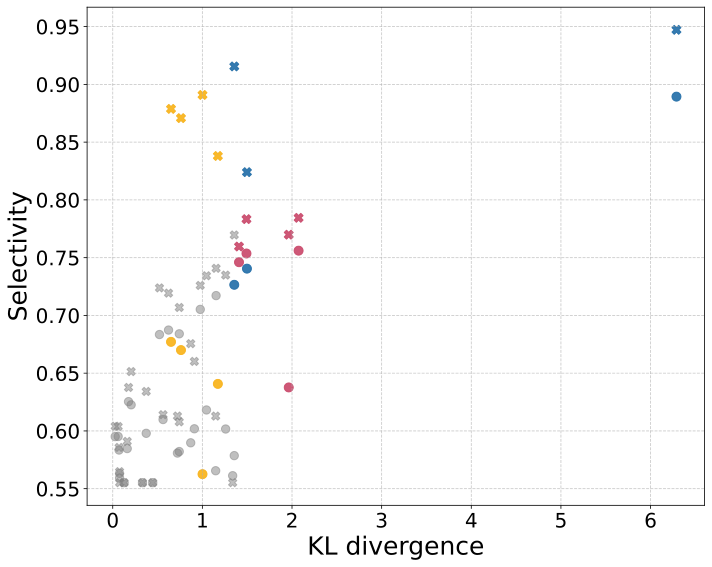

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
# Plot all receptors in gray with specific markers by valency
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["KL Divergence"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL divergence", fontsize=25)
ax.set_ylabel("Selectivity", fontsize=25)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.tight_layout()
plt.show()

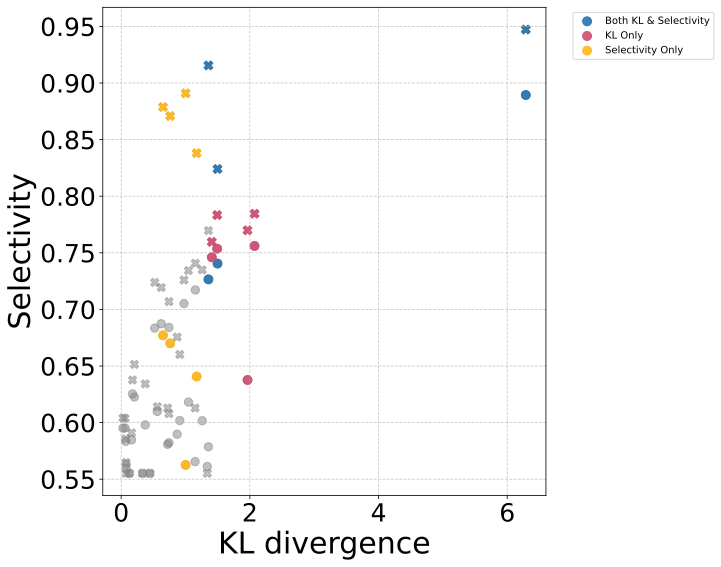

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
# Plot all receptors in gray with specific markers by valency
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["KL Divergence"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL divergence", fontsize=30)
ax.set_ylabel("Selectivity", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

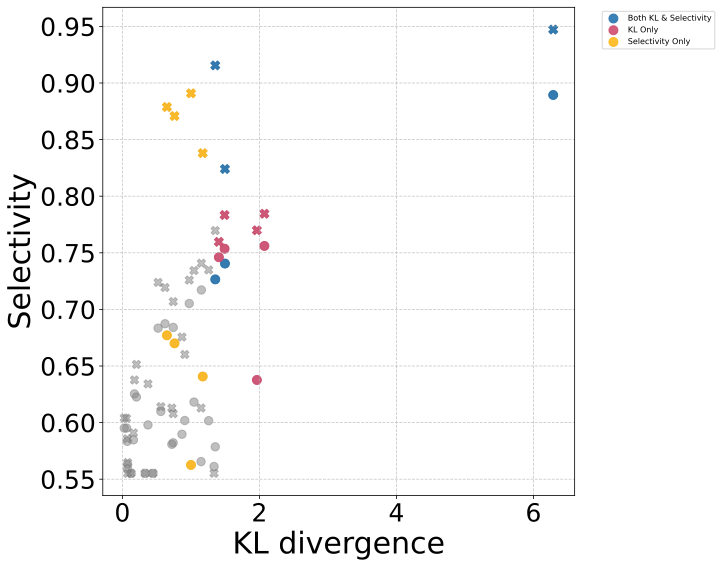

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
# Plot all receptors in gray with specific markers by valency
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["KL Divergence"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL divergence", fontsize=30)
ax.set_ylabel("Selectivity", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

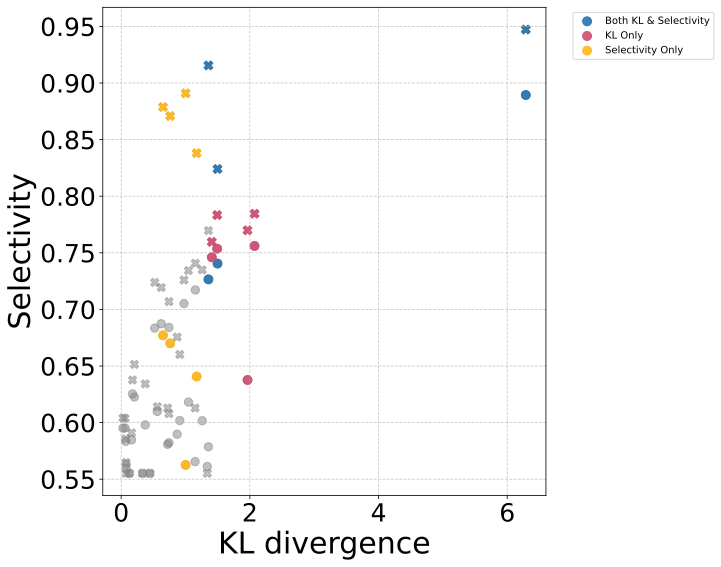

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
# Plot all receptors in gray with specific markers by valency
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["KL Divergence"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL divergence", fontsize=30)
ax.set_ylabel("Selectivity", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

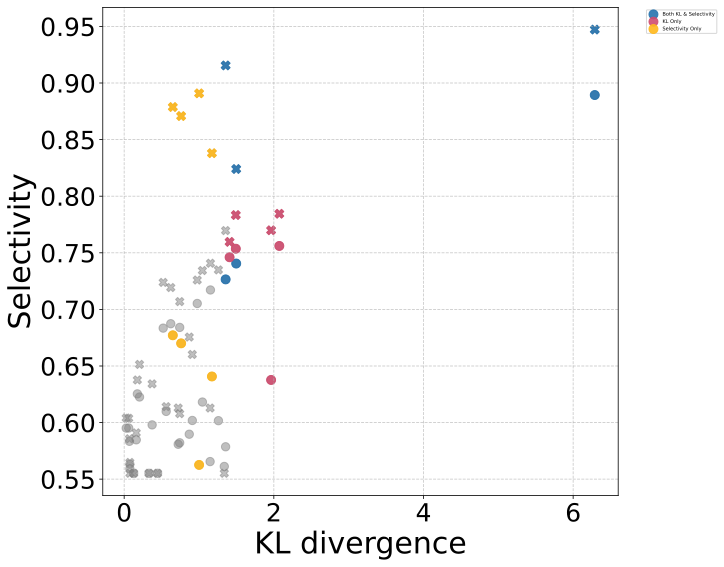

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
# Plot all receptors in gray with specific markers by valency
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["KL Divergence"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL divergence", fontsize=30)
ax.set_ylabel("Selectivity", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=5)
plt.tight_layout()
plt.show()

In [ ]:
# Get top 7 receptors for each metric (each receptor counted once)
top_kl_indices = unique_receptors_df["KL Divergence"].nlargest(7).index.tolist()
top_kl_receptors = unique_receptors_df.iloc[top_kl_indices][
    "Receptor Pair"
].tolist()

top_emd_indices = unique_receptors_df["EMD"].nlargest(7).index.tolist()
top_emd_receptors = unique_receptors_df.iloc[top_emd_indices][
    "Receptor Pair"
].tolist()

# Get top 7 selectivity receptors (taking best selectivity per receptor across valencies)
selectivity_per_receptor = metrics_df.dropna(subset=["Selectivity"]).groupby("Receptor Pair")["Selectivity"].max().reset_index()
top_selectivity_data = selectivity_per_receptor.nlargest(7, "Selectivity")
top_selectivity_receptors = top_selectivity_data["Receptor Pair"].tolist()

# Create categories for KL plot
kl_both = set(top_kl_receptors).intersection(set(top_selectivity_receptors))
kl_only = set(top_kl_receptors) - set(top_selectivity_receptors)
selectivity_only_kl = set(top_selectivity_receptors) - set(top_kl_receptors)

# Create categories for EMD plot
emd_both = set(top_emd_receptors).intersection(set(top_selectivity_receptors))
emd_only = set(top_emd_receptors) - set(top_selectivity_receptors)
selectivity_only_emd = set(top_selectivity_receptors) - set(top_emd_receptors)

# Filter dataframes for KL plot categories
metrics_df_kl_both = metrics_df[metrics_df["Receptor Pair"].isin(kl_both)]
metrics_df_kl_only = metrics_df[metrics_df["Receptor Pair"].isin(kl_only)]
metrics_df_selectivity_only_kl = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_kl)]

# Filter dataframes for EMD plot categories
metrics_df_emd_both = metrics_df[metrics_df["Receptor Pair"].isin(emd_both)]
metrics_df_emd_only = metrics_df[metrics_df["Receptor Pair"].isin(emd_only)]
metrics_df_selectivity_only_emd = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_emd)]

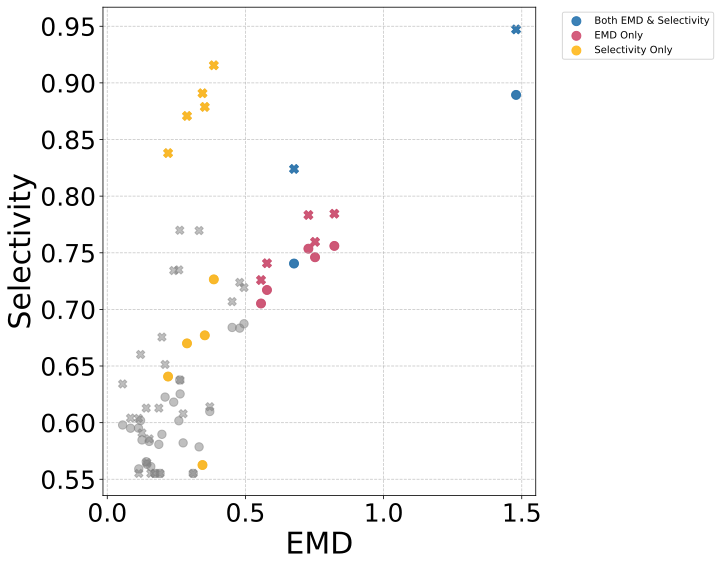

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["EMD"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both EMD and selectivity (blue)
if len(metrics_df_emd_both) > 0:
    for valency in metrics_df_emd_both["Valency"].unique():
        subset = metrics_df_emd_both[metrics_df_emd_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both EMD & Selectivity" if valency == metrics_df_emd_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by EMD (red)
if len(metrics_df_emd_only) > 0:
    for valency in metrics_df_emd_only["Valency"].unique():
        subset = metrics_df_emd_only[metrics_df_emd_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="EMD Only" if valency == metrics_df_emd_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_emd) > 0:
    for valency in metrics_df_selectivity_only_emd["Valency"].unique():
        subset = metrics_df_selectivity_only_emd[metrics_df_selectivity_only_emd["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_emd["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("EMD", fontsize=30)
ax.set_ylabel("Selectivity", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
# ax.set_title("EMD vs Selectivity (Top 5 Receptors by Category)", fontsize=30)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

from bicytok.imports import importCITE, sample_receptor_abundances
from bicytok.selectivity_funcs import optimize_affs

import time

# receptors = ["CD25", "CD4-1", "CD27", "CD4-2", "CD278"]
receptors = ["CD25", "CD4-1", "CD27", "CD4-2"]
signal = ["CD122"]
cell_type = "Treg"
dose = 1e-10
valency = np.array([[2, 1, 1]])
cell_categorization = "CellType2"
sample_size = 100

CITE_DF = importCITE()

epitopes = [
    col
    for col in CITE_DF.columns
    if col not in ["CellType1", "CellType2", "CellType3"]
]
epitopes_df = CITE_DF[epitopes + [cell_categorization]]
epitopes_df = epitopes_df.rename(columns={cell_categorization: "Cell Type"})
sample_df = sample_receptor_abundances(epitopes_df, sample_size, cell_type)

targ_mask = (sample_df["Cell Type"] == cell_type).to_numpy()
off_targ_mask = ~targ_mask

signal_abun = sample_df[signal].to_numpy()

# Generate all possible combinations of 2 receptors from the receptor list
receptor_combinations = list(combinations(receptors, 2))

selectivities = []
combination_names = []

for rec1, rec2 in receptor_combinations:
    time_start = time.time()

    rec1_abun = sample_df[[rec1]].to_numpy()
    rec2_abun = sample_df[[rec2]].to_numpy()

    receptor_abuns = np.hstack((signal_abun, rec1_abun, rec2_abun))

    targ_abun = receptor_abuns[targ_mask]
    off_targ_abun = receptor_abuns[off_targ_mask]

    opt_selec, _, _ = optimize_affs(targ_abun, off_targ_abun, dose, valencies=valency)
    
    selectivities.append(1 / opt_selec)
    combination_names.append(f"{signal[0]}+{rec1}+{rec2}")

    time_end = time.time()
    print(f"Processed combination {rec1}, {rec2} in {time_end - time_start:.2f} seconds")

# Create DataFrame with results
results_df = pd.DataFrame({
    'Combination': combination_names,
    'Selectivity': selectivities
})

# Sort by selectivity and get top 10
results_df = results_df.sort_values('Selectivity', ascending=False).head(10)

Processed combination CD25, CD4-1 in 1.13 seconds
Processed combination CD25, CD27 in 1.64 seconds
Processed combination CD25, CD4-2 in 1.52 seconds
Processed combination CD4-1, CD27 in 1.15 seconds
Processed combination CD4-1, CD4-2 in 1.17 seconds
Processed combination CD27, CD4-2 in 1.57 seconds


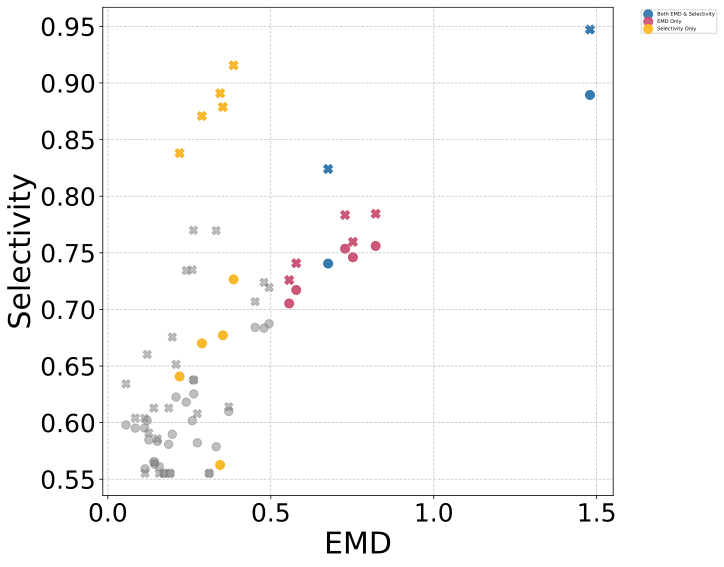

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["EMD"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both EMD and selectivity (blue)
if len(metrics_df_emd_both) > 0:
    for valency in metrics_df_emd_both["Valency"].unique():
        subset = metrics_df_emd_both[metrics_df_emd_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both EMD & Selectivity" if valency == metrics_df_emd_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by EMD (red)
if len(metrics_df_emd_only) > 0:
    for valency in metrics_df_emd_only["Valency"].unique():
        subset = metrics_df_emd_only[metrics_df_emd_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="EMD Only" if valency == metrics_df_emd_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_emd) > 0:
    for valency in metrics_df_selectivity_only_emd["Valency"].unique():
        subset = metrics_df_selectivity_only_emd[metrics_df_selectivity_only_emd["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_emd["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("EMD", fontsize=30)
ax.set_ylabel("Selectivity", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
# ax.set_title("EMD vs Selectivity (Top 5 Receptors by Category)", fontsize=30)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=5)
plt.tight_layout()
plt.show()

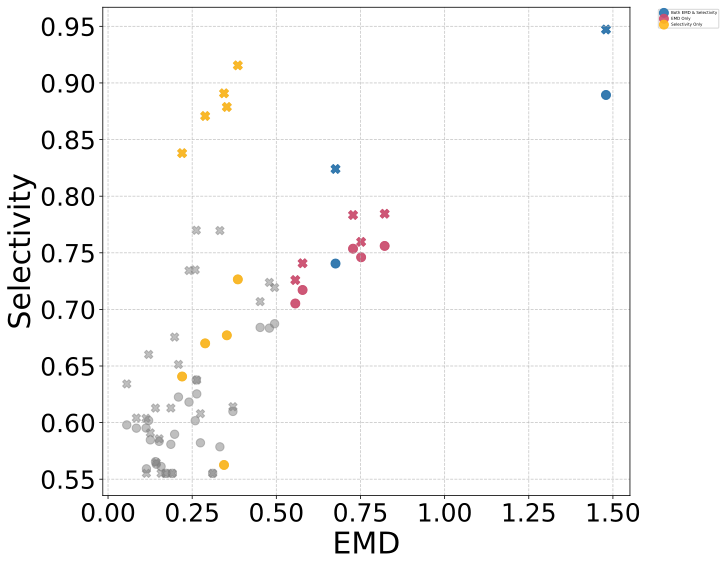

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["EMD"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both EMD and selectivity (blue)
if len(metrics_df_emd_both) > 0:
    for valency in metrics_df_emd_both["Valency"].unique():
        subset = metrics_df_emd_both[metrics_df_emd_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both EMD & Selectivity" if valency == metrics_df_emd_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by EMD (red)
if len(metrics_df_emd_only) > 0:
    for valency in metrics_df_emd_only["Valency"].unique():
        subset = metrics_df_emd_only[metrics_df_emd_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="EMD Only" if valency == metrics_df_emd_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_emd) > 0:
    for valency in metrics_df_selectivity_only_emd["Valency"].unique():
        subset = metrics_df_selectivity_only_emd[metrics_df_selectivity_only_emd["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_emd["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("EMD", fontsize=30)
ax.set_ylabel("Selectivity", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
# ax.set_title("EMD vs Selectivity (Top 5 Receptors by Category)", fontsize=30)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=4)
plt.tight_layout()
plt.show()

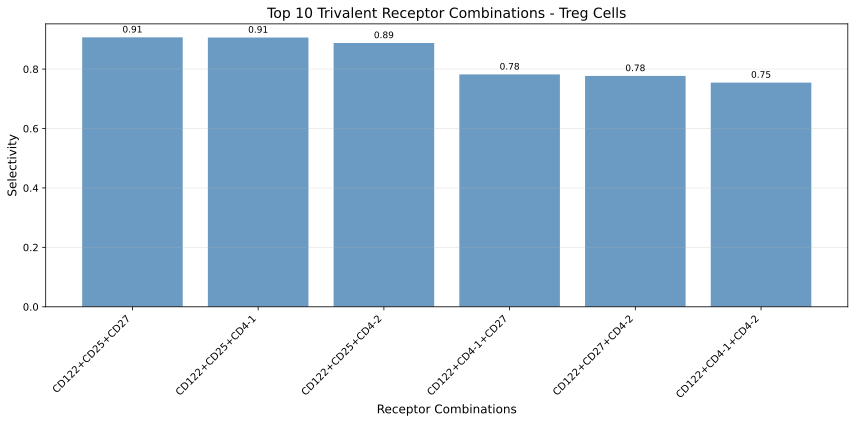

In [ ]:
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(results_df)), results_df['Selectivity'], 
               color='steelblue', alpha=0.8)

plt.xlabel('Receptor Combinations', fontsize=12)
plt.ylabel('Selectivity', fontsize=12)
plt.title(f'Top 10 Trivalent Receptor Combinations - {cell_type} Cells', fontsize=14)

# Set x-axis labels
plt.xticks(range(len(results_df)), results_df['Combination'], 
           rotation=45, ha='right', fontsize=10)

# Add value labels on top of bars
for i, (bar, value) in enumerate(zip(bars, results_df['Selectivity'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.2f}', ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

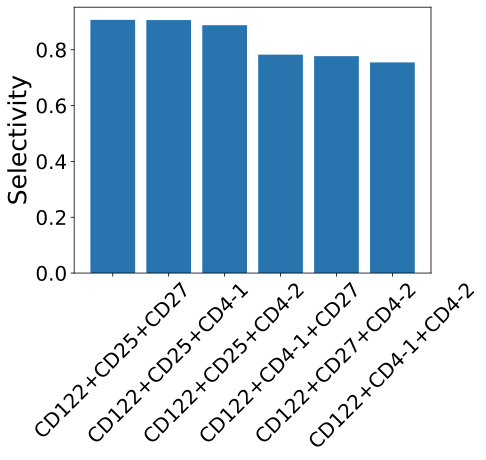

In [ ]:
plt.bar(
    results_df['Combination'],
    results_df['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45)
plt.show()

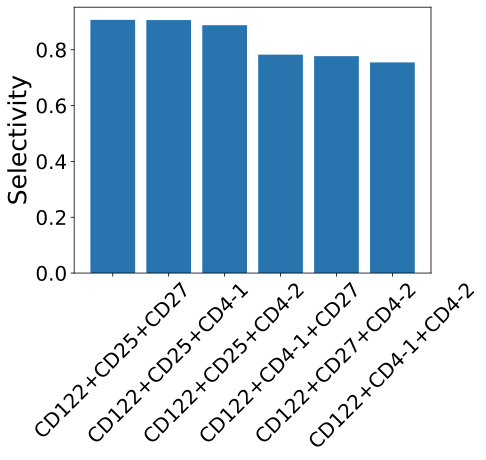

In [ ]:
plt.bar(
    results_df['Combination'],
    results_df['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45)
plt.show()

In [ ]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

from bicytok.imports import importCITE, sample_receptor_abundances
from bicytok.selectivity_funcs import optimize_affs

import time

# receptors = ["CD25", "CD4-1", "CD27", "CD4-2", "CD278"]
receptors = ["CD25", "CD4-1", "CD27", "CD4-2"]
signal = ["CD122"]
cell_type = "Treg"
dose = 1e-10
valency = np.array([[2, 1, 1]])
cell_categorization = "CellType2"
sample_size = 100

CITE_DF = importCITE()

epitopes = [
    col
    for col in CITE_DF.columns
    if col not in ["CellType1", "CellType2", "CellType3"]
]
epitopes_df = CITE_DF[epitopes + [cell_categorization]]
epitopes_df = epitopes_df.rename(columns={cell_categorization: "Cell Type"})
sample_df = sample_receptor_abundances(epitopes_df, sample_size, cell_type)

targ_mask = (sample_df["Cell Type"] == cell_type).to_numpy()
off_targ_mask = ~targ_mask

signal_abun = sample_df[signal].to_numpy()

# Generate all possible combinations of 2 receptors from the receptor list (including same receptor twice)
receptor_combinations = list(combinations_with_replacement(receptors, 2))

selectivities = []
combination_names = []

for rec1, rec2 in receptor_combinations:
    time_start = time.time()

    rec1_abun = sample_df[[rec1]].to_numpy()
    rec2_abun = sample_df[[rec2]].to_numpy()

    receptor_abuns = np.hstack((signal_abun, rec1_abun, rec2_abun))

    targ_abun = receptor_abuns[targ_mask]
    off_targ_abun = receptor_abuns[off_targ_mask]

    opt_selec, _, _ = optimize_affs(targ_abun, off_targ_abun, dose, valencies=valency)
    
    selectivities.append(1 / opt_selec)
    combination_names.append(f"{rec1}+{rec2}")

    time_end = time.time()
    print(f"Processed combination {rec1}, {rec2} in {time_end - time_start:.2f} seconds")

# Create DataFrame with results
results_df = pd.DataFrame({
    'Combination': combination_names,
    'Selectivity': selectivities
})

# Sort by selectivity and get top 10 (ascending order - lowest to highest)
results_df = results_df.sort_values('Selectivity', ascending=True).head(10)

Processed combination CD25, CD25 in 1.42 seconds
Processed combination CD25, CD4-1 in 1.30 seconds
Processed combination CD25, CD27 in 0.87 seconds
Processed combination CD25, CD4-2 in 1.26 seconds
Processed combination CD4-1, CD4-1 in 2.13 seconds
Processed combination CD4-1, CD27 in 1.24 seconds
Processed combination CD4-1, CD4-2 in 2.01 seconds
Processed combination CD27, CD27 in 1.04 seconds
Processed combination CD27, CD4-2 in 1.36 seconds
Processed combination CD4-2, CD4-2 in 1.24 seconds


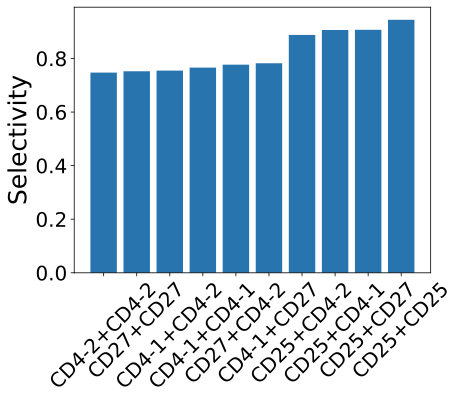

In [ ]:
plt.bar(
    results_df['Combination'],
    results_df['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45)
plt.show()

In [ ]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

from bicytok.imports import importCITE, sample_receptor_abundances
from bicytok.selectivity_funcs import optimize_affs

import time

# receptors = ["CD25", "CD4-1", "CD27", "CD4-2", "CD278"]
receptors = ["CD25", "CD4-1", "CD27", "CD4-2"]
signal = ["CD122"]
cell_type = "Treg"
dose = 1e-10
valency = np.array([[2, 1, 1]])
cell_categorization = "CellType2"
sample_size = 100

CITE_DF = importCITE()

epitopes = [
    col
    for col in CITE_DF.columns
    if col not in ["CellType1", "CellType2", "CellType3"]
]
epitopes_df = CITE_DF[epitopes + [cell_categorization]]
epitopes_df = epitopes_df.rename(columns={cell_categorization: "Cell Type"})
sample_df = sample_receptor_abundances(epitopes_df, sample_size, cell_type)

targ_mask = (sample_df["Cell Type"] == cell_type).to_numpy()
off_targ_mask = ~targ_mask

signal_abun = sample_df[signal].to_numpy()

# Generate all possible combinations of 2 receptors from the receptor list (including same receptor twice)
receptor_combinations = list(combinations_with_replacement(receptors, 2))

selectivities = []
combination_names = []

for rec1, rec2 in receptor_combinations:
    time_start = time.time()

    rec1_abun = sample_df[[rec1]].to_numpy()
    rec2_abun = sample_df[[rec2]].to_numpy()

    receptor_abuns = np.hstack((signal_abun, rec1_abun, rec2_abun))

    targ_abun = receptor_abuns[targ_mask]
    off_targ_abun = receptor_abuns[off_targ_mask]

    opt_selec, _, _ = optimize_affs(targ_abun, off_targ_abun, dose, valencies=valency)
    
    selectivities.append(1 / opt_selec)
    combination_names.append(f"{rec1}+{rec2}")

    time_end = time.time()
    print(f"Processed combination {rec1}, {rec2} in {time_end - time_start:.2f} seconds")

# Create DataFrame with results
results_df = pd.DataFrame({
    'Combination': combination_names,
    'Selectivity': selectivities
})

Processed combination CD25, CD25 in 1.29 seconds
Processed combination CD25, CD4-1 in 1.01 seconds
Processed combination CD25, CD27 in 1.22 seconds
Processed combination CD25, CD4-2 in 1.36 seconds
Processed combination CD4-1, CD4-1 in 1.23 seconds
Processed combination CD4-1, CD27 in 1.24 seconds
Processed combination CD4-1, CD4-2 in 1.86 seconds
Processed combination CD27, CD27 in 1.13 seconds
Processed combination CD27, CD4-2 in 1.21 seconds
Processed combination CD4-2, CD4-2 in 1.38 seconds


In [ ]:
# Sort by selectivity and get top 5 (ascending order - lowest to highest)
results_df_filt = results_df.sort_values('Selectivity', ascending=True).head(5)

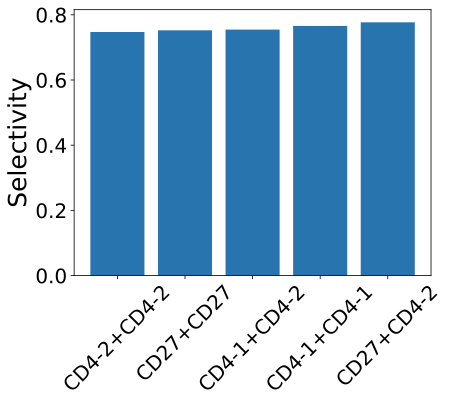

In [ ]:
plt.bar(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45)
plt.show()

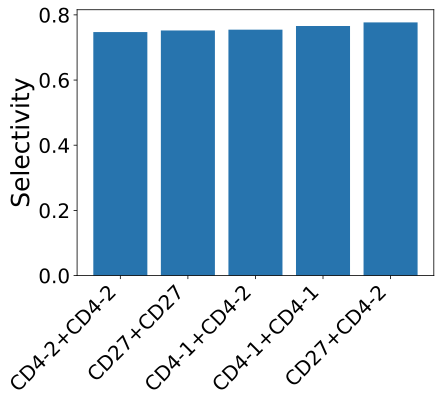

In [ ]:
plt.bar(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

from bicytok.imports import importCITE, sample_receptor_abundances
from bicytok.selectivity_funcs import optimize_affs

import time

# receptors = ["CD25", "CD4-1", "CD27", "CD4-2", "CD278"]
receptors = ["CD25", "CD4-1", "CD27", "CD4-2"]
signal = ["CD122"]
cell_type = "Treg"
dose = 1e-10
valency = np.array([[2, 1, 1]])
cell_categorization = "CellType2"
sample_size = 100

CITE_DF = importCITE()

epitopes = [
    col
    for col in CITE_DF.columns
    if col not in ["CellType1", "CellType2", "CellType3"]
]
epitopes_df = CITE_DF[epitopes + [cell_categorization]]
epitopes_df = epitopes_df.rename(columns={cell_categorization: "Cell Type"})
sample_df = sample_receptor_abundances(epitopes_df, sample_size, cell_type)

targ_mask = (sample_df["Cell Type"] == cell_type).to_numpy()
off_targ_mask = ~targ_mask

signal_abun = sample_df[signal].to_numpy()

# Generate all possible combinations of 2 receptors from the receptor list (including same receptor twice)
receptor_combinations = list(combinations_with_replacement(receptors, 2))

selectivities = []
combination_names = []

for rec1, rec2 in receptor_combinations:
    time_start = time.time()

    rec1_abun = sample_df[[rec1]].to_numpy()
    rec2_abun = sample_df[[rec2]].to_numpy()

    receptor_abuns = np.hstack((signal_abun, rec1_abun, rec2_abun))

    targ_abun = receptor_abuns[targ_mask]
    off_targ_abun = receptor_abuns[off_targ_mask]

    opt_selec, _, _ = optimize_affs(targ_abun, off_targ_abun, dose, valencies=valency)
    
    selectivities.append(1 / opt_selec)
    combination_names.append(f"{rec1}+{rec2}")

    time_end = time.time()
    print(f"Processed combination {rec1}, {rec2} in {time_end - time_start:.2f} seconds")

# Create DataFrame with results
results_df = pd.DataFrame({
    'Combination': combination_names,
    'Selectivity': selectivities
})

Processed combination CD25, CD25 in 1.18 seconds
Processed combination CD25, CD4-1 in 1.45 seconds
Processed combination CD25, CD27 in 1.19 seconds
Processed combination CD25, CD4-2 in 1.26 seconds
Processed combination CD4-1, CD4-1 in 1.33 seconds
Processed combination CD4-1, CD27 in 0.90 seconds
Processed combination CD4-1, CD4-2 in 1.28 seconds
Processed combination CD27, CD27 in 1.53 seconds
Processed combination CD27, CD4-2 in 0.99 seconds
Processed combination CD4-2, CD4-2 in 1.98 seconds


In [ ]:
# Sort by selectivity and get top 5 (ascending order - lowest to highest)
results_df_filt = results_df.sort_values('Selectivity', ascending=True).head(5)

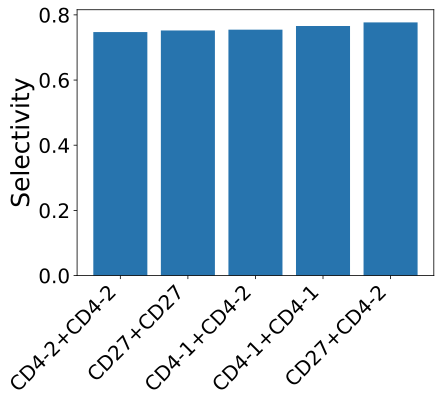

In [ ]:
plt.bar(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Sort by selectivity and get top 5 (descending order - highest to lowest)
results_df_filt = results_df.sort_values('Selectivity', ascending=False).head(5)

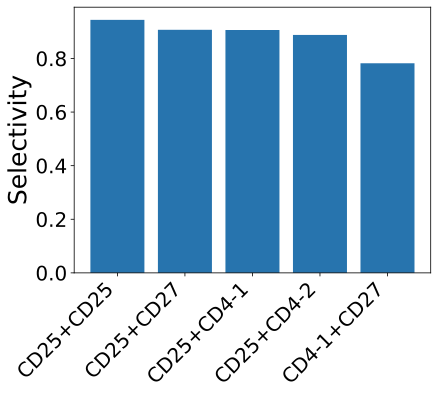

In [ ]:
plt.bar(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Sort by selectivity and get top 5 (descending order - highest to lowest)
results_df_filt = results_df.sort_values('Selectivity', ascending=False).head(5)
# Reverse order for display (highest to lowest from left to right)
results_df_filt = results_df_filt.iloc[::-1]

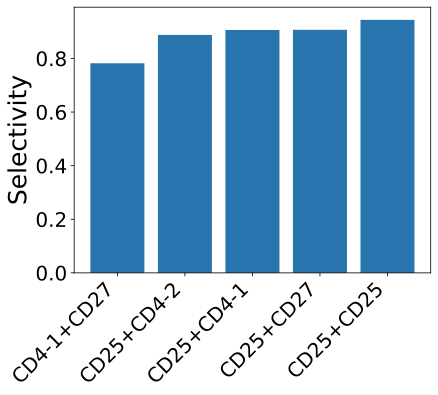

In [ ]:
plt.bar(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Sort by selectivity and get top 5 (descending order - highest to lowest)
results_df_filt = results_df.sort_values('Selectivity', ascending=False).head(10)
# Reverse order for display (highest to lowest from left to right)
results_df_filt = results_df_filt.iloc[::-1]

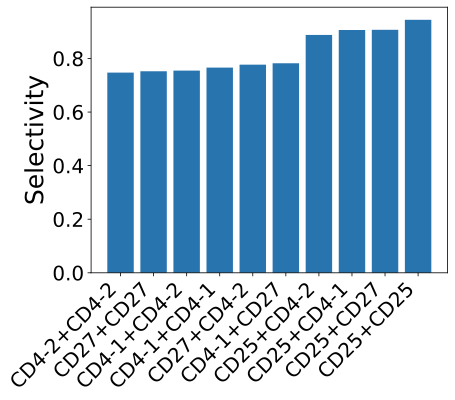

In [ ]:
plt.bar(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

from bicytok.imports import importCITE, sample_receptor_abundances
from bicytok.selectivity_funcs import optimize_affs

import time

# receptors = ["CD25", "CD4-1", "CD27", "CD4-2", "CD278"]
receptors = ["CD25", "CD4-1", "CD27", "CD4-2"]
signal = ["CD122"]
cell_type = "Treg"
dose = 1e-10
valency = np.array([[2, 1, 1]])
cell_categorization = "CellType2"
sample_size = 1000

CITE_DF = importCITE()

epitopes = [
    col
    for col in CITE_DF.columns
    if col not in ["CellType1", "CellType2", "CellType3"]
]
epitopes_df = CITE_DF[epitopes + [cell_categorization]]
epitopes_df = epitopes_df.rename(columns={cell_categorization: "Cell Type"})
sample_df = sample_receptor_abundances(epitopes_df, sample_size, cell_type)

targ_mask = (sample_df["Cell Type"] == cell_type).to_numpy()
off_targ_mask = ~targ_mask

signal_abun = sample_df[signal].to_numpy()

# Generate all possible combinations of 2 receptors from the receptor list (including same receptor twice)
receptor_combinations = list(combinations_with_replacement(receptors, 2))

selectivities = []
combination_names = []

for rec1, rec2 in receptor_combinations:
    time_start = time.time()

    rec1_abun = sample_df[[rec1]].to_numpy()
    rec2_abun = sample_df[[rec2]].to_numpy()

    receptor_abuns = np.hstack((signal_abun, rec1_abun, rec2_abun))

    targ_abun = receptor_abuns[targ_mask]
    off_targ_abun = receptor_abuns[off_targ_mask]

    opt_selec, _, _ = optimize_affs(targ_abun, off_targ_abun, dose, valencies=valency)
    
    selectivities.append(1 / opt_selec)
    combination_names.append(f"{rec1}+{rec2}")

    time_end = time.time()
    print(f"Processed combination {rec1}, {rec2} in {time_end - time_start:.2f} seconds")

# Create DataFrame with results
results_df = pd.DataFrame({
    'Combination': combination_names,
    'Selectivity': selectivities
})

Processed combination CD25, CD25 in 32.84 seconds
Processed combination CD25, CD4-1 in 13.99 seconds
Processed combination CD25, CD27 in 13.87 seconds
Processed combination CD25, CD4-2 in 19.59 seconds
Processed combination CD4-1, CD4-1 in 14.34 seconds
Processed combination CD4-1, CD27 in 8.70 seconds
Processed combination CD4-1, CD4-2 in 11.37 seconds
Processed combination CD27, CD27 in 12.50 seconds
Processed combination CD27, CD4-2 in 10.08 seconds
Processed combination CD4-2, CD4-2 in 10.88 seconds


In [ ]:
# Sort by selectivity and get top 5 (descending order - highest to lowest)
results_df_filt = results_df.sort_values('Selectivity', ascending=False).head(10)
# Reverse order for display (highest to lowest from left to right)
results_df_filt = results_df_filt.iloc[::-1]

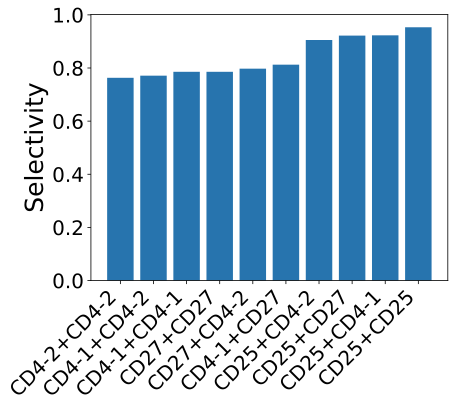

In [ ]:
plt.bar(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

from bicytok.imports import importCITE, sample_receptor_abundances
from bicytok.selectivity_funcs import optimize_affs

import time

# receptors = ["CD25", "CD4-1", "CD27", "CD4-2", "CD278"]
receptors = ["CD25", "CD4-1", "CD27", "CD278", "CD338", "CCR10", "CD243"]
signal = ["CD122"]
cell_type = "Treg"
dose = 1e-10
valency = np.array([[2, 1, 1]])
cell_categorization = "CellType2"
sample_size = 1000

CITE_DF = importCITE()

epitopes = [
    col
    for col in CITE_DF.columns
    if col not in ["CellType1", "CellType2", "CellType3"]
]
epitopes_df = CITE_DF[epitopes + [cell_categorization]]
epitopes_df = epitopes_df.rename(columns={cell_categorization: "Cell Type"})
sample_df = sample_receptor_abundances(epitopes_df, sample_size, cell_type)

targ_mask = (sample_df["Cell Type"] == cell_type).to_numpy()
off_targ_mask = ~targ_mask

signal_abun = sample_df[signal].to_numpy()

# Generate all possible combinations of 2 receptors from the receptor list (including same receptor twice)
receptor_combinations = list(combinations_with_replacement(receptors, 2))

selectivities = []
combination_names = []

for rec1, rec2 in receptor_combinations:
    time_start = time.time()

    rec1_abun = sample_df[[rec1]].to_numpy()
    rec2_abun = sample_df[[rec2]].to_numpy()

    receptor_abuns = np.hstack((signal_abun, rec1_abun, rec2_abun))

    targ_abun = receptor_abuns[targ_mask]
    off_targ_abun = receptor_abuns[off_targ_mask]

    opt_selec, _, _ = optimize_affs(targ_abun, off_targ_abun, dose, valencies=valency)
    
    selectivities.append(1 / opt_selec)
    combination_names.append(f"{rec1}+{rec2}")

    time_end = time.time()
    print(f"Processed combination {rec1}, {rec2} in {time_end - time_start:.2f} seconds")

# Create DataFrame with results
results_df = pd.DataFrame({
    'Combination': combination_names,
    'Selectivity': selectivities
})

Processed combination CD25, CD25 in 12.56 seconds
Processed combination CD25, CD4-1 in 15.64 seconds
Processed combination CD25, CD27 in 10.13 seconds
Processed combination CD25, CD278 in 12.52 seconds
Processed combination CD25, CD338 in 20.58 seconds
Processed combination CD25, CCR10 in 45.58 seconds
Processed combination CD25, CD243 in 18.21 seconds
Processed combination CD4-1, CD4-1 in 19.30 seconds
Processed combination CD4-1, CD27 in 11.54 seconds
Processed combination CD4-1, CD278 in 11.40 seconds
Processed combination CD4-1, CD338 in 23.01 seconds
Processed combination CD4-1, CCR10 in 37.48 seconds
Processed combination CD4-1, CD243 in 16.66 seconds
Processed combination CD27, CD27 in 12.20 seconds
Processed combination CD27, CD278 in 15.24 seconds
Processed combination CD27, CD338 in 14.98 seconds
Processed combination CD27, CCR10 in 19.00 seconds
Processed combination CD27, CD243 in 19.26 seconds
Processed combination CD278, CD278 in 16.77 seconds
Processed combination CD278,

In [ ]:
# Sort by selectivity and get top 5 (descending order - highest to lowest)
results_df_filt = results_df.sort_values('Selectivity', ascending=False).head(10)
# Reverse order for display (highest to lowest from left to right)
results_df_filt = results_df_filt.iloc[::-1]

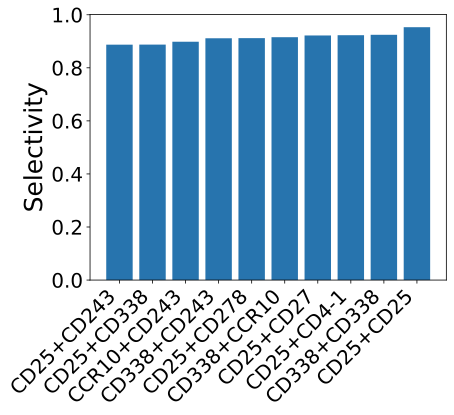

In [ ]:
plt.bar(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from bicytok.distance_metric_funcs import KL_EMD_1D
from bicytok.imports import importCITE, sample_receptor_abundances

plt.rcParams["svg.fonttype"] = "none"

receptor = "CD338"
targ_cell = "Treg"
sample_size = 356*2
cell_categorization = "CellType2"
plot_cell_types = [targ_cell, "other"]
stat = "count"
x_limit = False
normalize = False

CITE_DF = importCITE()

assert targ_cell in CITE_DF[cell_categorization].unique()

epitopes = [
    col
    for col in CITE_DF.columns
    if col not in ["Cell", "CellType1", "CellType2", "CellType3"]
]
if receptor not in epitopes:
    raise ValueError(
        f"Receptor '{receptor}' not found. Available receptors: {epitopes}"
    )

# Use converted receptor abundances to calculate metric values
epitopes_df = CITE_DF[epitopes + [cell_categorization]]
epitopes_df = epitopes_df.rename(columns={cell_categorization: "Cell Type"})
sample_df = sample_receptor_abundances(
    CITE_DF=epitopes_df,
    numCells=min(sample_size, epitopes_df.shape[0]),
    targCellType=targ_cell,
    balance=True,
    rand_state=42,
)
targ_mask = (sample_df["Cell Type"] == targ_cell).to_numpy()
off_targ_mask = ~targ_mask
rec_abundances = sample_df[[receptor]].to_numpy()
KL_div_vals, EMD_vals = KL_EMD_1D(rec_abundances, targ_mask, off_targ_mask)
kl_val = KL_div_vals[0]
emd_val = EMD_vals[0]

# Use raw receptor counts for plotting
sample_df = sample_receptor_abundances(
    CITE_DF=epitopes_df,
    numCells=min(sample_size, epitopes_df.shape[0]),
    targCellType=targ_cell,
    balance=False,
    rand_state=42,
)
targ_mask = (sample_df["Cell Type"] == targ_cell).to_numpy()
sample_df.loc[sample_df["Cell Type"] != targ_cell, "Cell Type"] = "other"

rec_abundance = sample_df[receptor].values
mean_abundance = np.mean(rec_abundance)
targ_abundances = rec_abundance[targ_mask]

all_cell_abundances = []
for cell_type in plot_cell_types:
    if cell_type not in sample_df["Cell Type"].unique():
        continue
    mask = (sample_df["Cell Type"] == cell_type).to_numpy()
    if normalize:
        all_cell_abundances.append(rec_abundance[mask] / mean_abundance)
    else:
        all_cell_abundances.append(rec_abundance[mask])

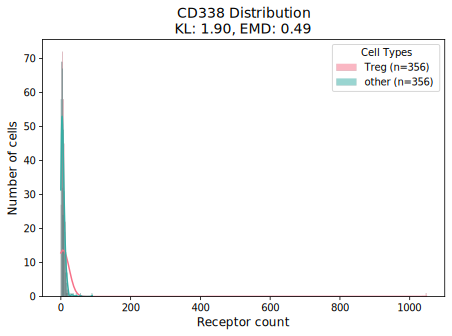

In [ ]:
colors = sns.color_palette("husl", len(all_cell_abundances))
for i, abundances in enumerate(all_cell_abundances):
    if len(abundances) == 0:
        continue
    sns.histplot(
        abundances,
        color=colors[i],
        alpha=0.5,
        label=f"{plot_cell_types[i]} (n={len(abundances)})",
        stat=stat,
        kde=True,
        kde_kws={"bw_method": "scott"},
    )

plt.title(
    f"{receptor} Distribution\nKL: {kl_val:.2f}, EMD: {emd_val:.2f}", fontsize=14
)
if normalize:
    plt.xlabel("Normalized receptor count", fontsize=12)
else:
    plt.xlabel("Receptor count", fontsize=12)

if stat == "density":
    plt.ylabel("Density", fontsize=12)
elif stat == "count":
    plt.ylabel("Number of cells", fontsize=12)
elif stat == "probability":
    plt.ylabel("Proportion of cells", fontsize=12)

x_max = np.percentile(targ_abundances, 99)
if x_limit:
    plt.xlim(0, x_max * 1.1)
plt.legend(loc="upper right", fontsize=10, title="Cell Types")
plt.tight_layout()
plt.show()

In [ ]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

from bicytok.imports import importCITE, sample_receptor_abundances
from bicytok.selectivity_funcs import optimize_affs

import time

receptors = ["CD25", "CD4-1", "CD27", "CD278", "CD338"]
signal = ["CD122"]
cell_type = "Treg"
dose = 1e-10
valency = np.array([[2, 1, 1]])
cell_categorization = "CellType2"
sample_size = 1000

CITE_DF = importCITE()

epitopes = [
    col
    for col in CITE_DF.columns
    if col not in ["CellType1", "CellType2", "CellType3"]
]
epitopes_df = CITE_DF[epitopes + [cell_categorization]]
epitopes_df = epitopes_df.rename(columns={cell_categorization: "Cell Type"})
sample_df = sample_receptor_abundances(epitopes_df, sample_size, cell_type)

targ_mask = (sample_df["Cell Type"] == cell_type).to_numpy()
off_targ_mask = ~targ_mask

signal_abun = sample_df[signal].to_numpy()

# Generate all possible combinations of 2 receptors from the receptor list (including same receptor twice)
receptor_combinations = list(combinations_with_replacement(receptors, 2))

selectivities = []
combination_names = []

for rec1, rec2 in receptor_combinations:
    time_start = time.time()

    rec1_abun = sample_df[[rec1]].to_numpy()
    rec2_abun = sample_df[[rec2]].to_numpy()

    receptor_abuns = np.hstack((signal_abun, rec1_abun, rec2_abun))

    targ_abun = receptor_abuns[targ_mask]
    off_targ_abun = receptor_abuns[off_targ_mask]

    opt_selec, _, _ = optimize_affs(targ_abun, off_targ_abun, dose, valencies=valency)
    
    selectivities.append(1 / opt_selec)
    combination_names.append(f"{rec1}+{rec2}")

    time_end = time.time()
    print(f"Processed combination {rec1}, {rec2} in {time_end - time_start:.2f} seconds")

# Create DataFrame with results
results_df = pd.DataFrame({
    'Combination': combination_names,
    'Selectivity': selectivities
})

Processed combination CD25, CD25 in 8.72 seconds
Processed combination CD25, CD4-1 in 12.54 seconds
Processed combination CD25, CD27 in 14.62 seconds
Processed combination CD25, CD278 in 10.48 seconds
Processed combination CD25, CD338 in 23.37 seconds
Processed combination CD4-1, CD4-1 in 13.74 seconds
Processed combination CD4-1, CD27 in 8.88 seconds
Processed combination CD4-1, CD278 in 12.54 seconds
Processed combination CD4-1, CD338 in 28.70 seconds
Processed combination CD27, CD27 in 8.35 seconds
Processed combination CD27, CD278 in 11.74 seconds
Processed combination CD27, CD338 in 17.71 seconds
Processed combination CD278, CD278 in 13.15 seconds
Processed combination CD278, CD338 in 19.36 seconds
Processed combination CD338, CD338 in 8.22 seconds


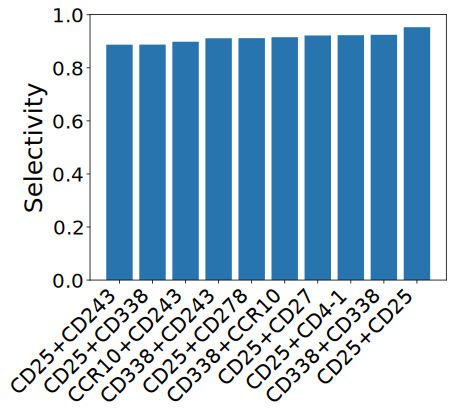

In [ ]:
plt.bar(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Sort by selectivity and get top 5 (descending order - highest to lowest)
results_df_filt = results_df.sort_values('Selectivity', ascending=False).head(10)
# Reverse order for display (highest to lowest from left to right)
results_df_filt = results_df_filt.iloc[::-1]

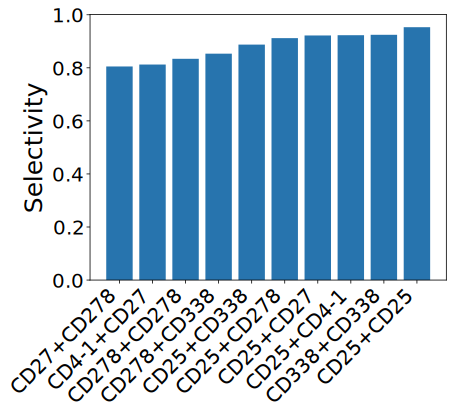

In [ ]:
plt.bar(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45, ha='right')
plt.show()

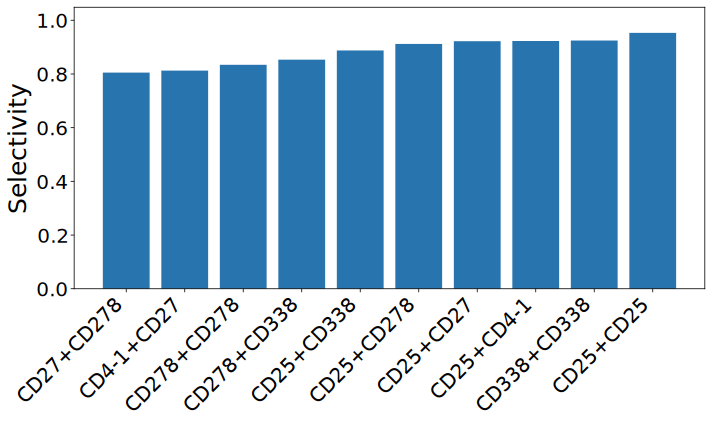

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(results_df_filt['Selectivity']) * 1.1)  # Set y-axis limits from 0 to 110% of max value
plt.tight_layout()
plt.show()

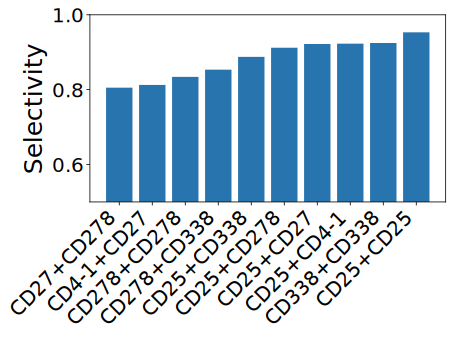

In [ ]:
plt.bar(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.show()

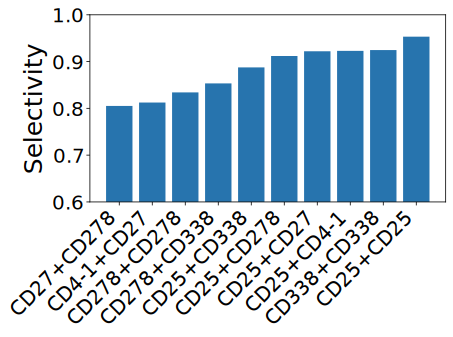

In [ ]:
plt.bar(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.6, 1.0)
plt.tight_layout()
plt.show()

In [ ]:
# Sort by selectivity and get top 5 (descending order - highest to lowest)
results_df_filt = results_df.sort_values('Selectivity', ascending=False).head(7)
# Reverse order for display (highest to lowest from left to right)
results_df_filt = results_df_filt.iloc[::-1]

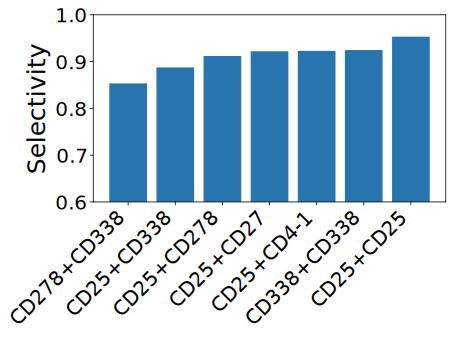

In [ ]:
plt.bar(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.6, 1.0)
plt.tight_layout()
plt.show()

In [ ]:
# Sort by selectivity and get top 5 (descending order - highest to lowest)
results_df_filt = results_df.sort_values('Selectivity', ascending=False).head(9)
# Reverse order for display (highest to lowest from left to right)
results_df_filt = results_df_filt.iloc[::-1]

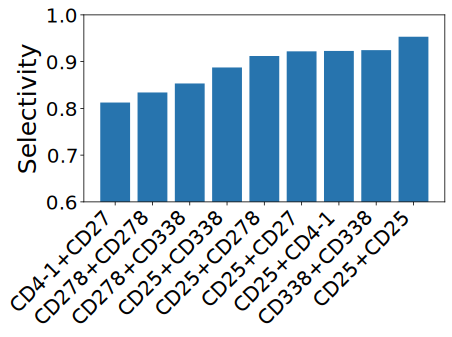

In [ ]:
plt.bar(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.6, 1.0)
plt.tight_layout()
plt.show()

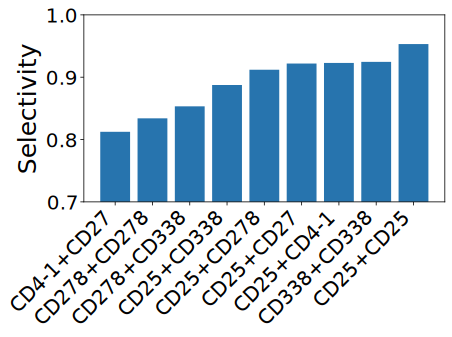

In [ ]:
plt.bar(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.ylabel("Selectivity", fontsize=25)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.7, 1.0)
plt.tight_layout()
plt.show()

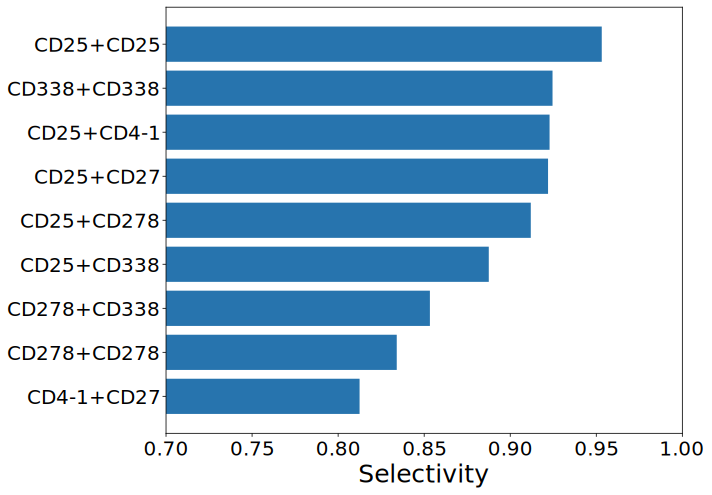

In [ ]:
# Create horizontal bar plot
plt.figure(figsize=(10, 7))  # Adjust figure size for better visibility
plt.barh(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="y", labelsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.xlabel("Selectivity", fontsize=25)
plt.xlim(0.7, 1.0)  # Same limits as before but now on x-axis
plt.tight_layout()
plt.show()

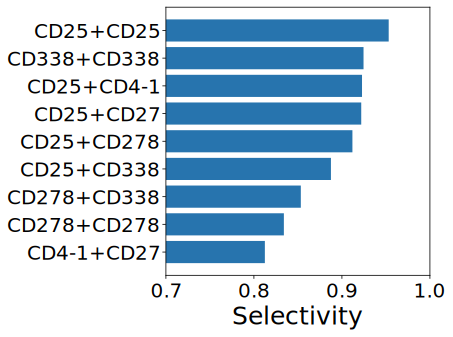

In [ ]:
# Create horizontal bar plot
# plt.figure(figsize=(10, 7))  # Adjust figure size for better visibility
plt.barh(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="y", labelsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.xlabel("Selectivity", fontsize=25)
plt.xlim(0.7, 1.0)  # Same limits as before but now on x-axis
plt.tight_layout()
plt.show()

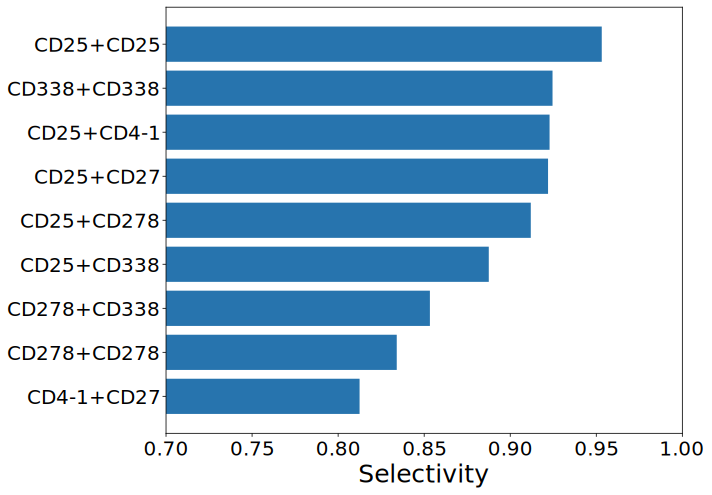

In [ ]:
# Create horizontal bar plot
plt.figure(figsize=(10, 7))
plt.barh(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="y", labelsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.xlabel("Selectivity", fontsize=25)
plt.xlim(0.7, 1.0)  # Same limits as before but now on x-axis
plt.tight_layout()
plt.show()

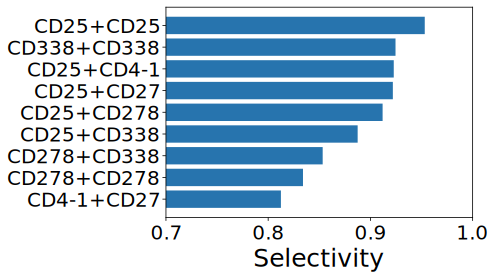

In [ ]:
# Create horizontal bar plot
plt.figure(figsize=(7, 4))
plt.barh(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="y", labelsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.xlabel("Selectivity", fontsize=25)
plt.xlim(0.7, 1.0)  # Same limits as before but now on x-axis
plt.tight_layout()
plt.show()

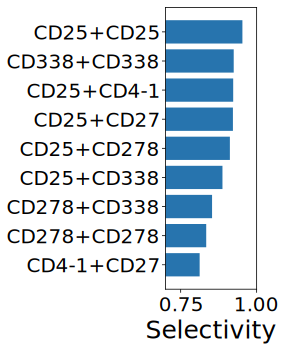

In [ ]:
# Create horizontal bar plot
plt.figure(figsize=(4, 5))
plt.barh(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="y", labelsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.xlabel("Selectivity", fontsize=25)
plt.xlim(0.7, 1.0)  # Same limits as before but now on x-axis
plt.tight_layout()
plt.show()

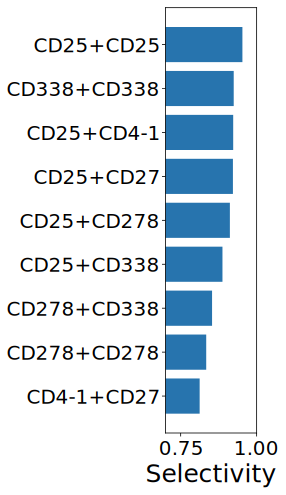

In [ ]:
# Create horizontal bar plot
plt.figure(figsize=(4, 7))
plt.barh(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="y", labelsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.xlabel("Selectivity", fontsize=25)
plt.xlim(0.7, 1.0)  # Same limits as before but now on x-axis
plt.tight_layout()
plt.show()

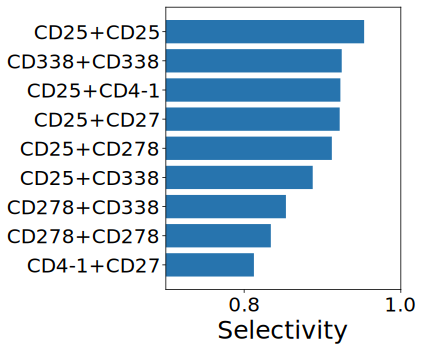

In [ ]:
# Create horizontal bar plot
plt.figure(figsize=(6, 5))
plt.barh(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="y", labelsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.xlabel("Selectivity", fontsize=25)
plt.xlim(0.7, 1.0)  # Same limits as before but now on x-axis
plt.tight_layout()
plt.show()

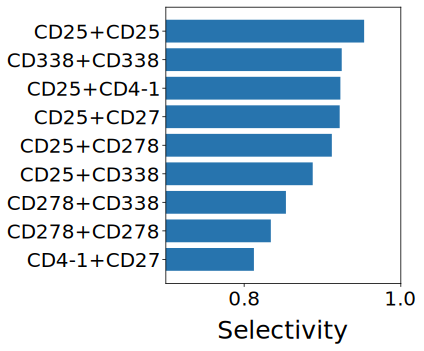

In [ ]:
# Create horizontal bar plot
plt.figure(figsize=(6, 5))
plt.barh(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="y", labelsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.xlabel("Selectivity", fontsize=25, labelpad=10)
plt.xlim(0.7, 1.0)  # Same limits as before but now on x-axis
plt.tight_layout()
plt.show()

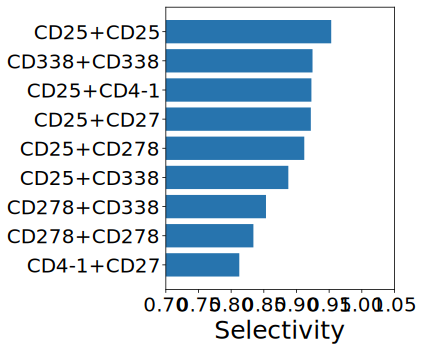

In [ ]:
# Create horizontal bar plot
plt.figure(figsize=(6, 5))
plt.barh(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="y", labelsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.xlabel("Selectivity", fontsize=25)
plt.xlim(0.7, 1.0)
# Add more tick labels to the x-axis
plt.xticks(np.arange(0.7, 1.05, 0.05))
plt.tight_layout()
plt.show()

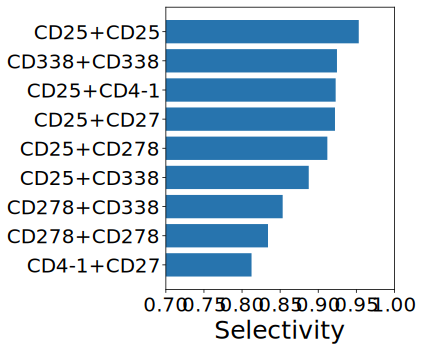

In [ ]:
# Create horizontal bar plot
plt.figure(figsize=(6, 5))
plt.barh(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="y", labelsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.xlabel("Selectivity", fontsize=25)
plt.xlim(0.7, 1.0)
# Add more tick labels to the x-axis
plt.xticks(np.arange(0.7, 1.00, 0.05))
plt.tight_layout()
plt.show()

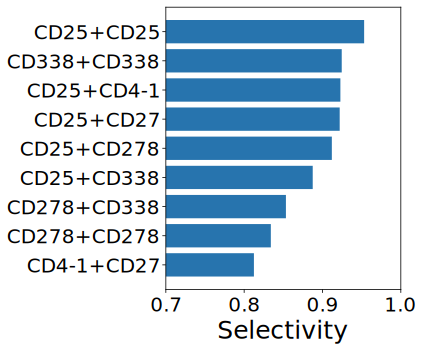

In [ ]:
# Create horizontal bar plot
plt.figure(figsize=(6, 5))
plt.barh(
    results_df_filt['Combination'],
    results_df_filt['Selectivity'],
    color="#2774AE",
)
plt.tick_params(axis="y", labelsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.xlabel("Selectivity", fontsize=25)
plt.xlim(0.7, 1.0)
# Add more tick labels to the x-axis
plt.xticks(np.arange(0.7, 1.00, 0.1))
plt.tight_layout()
plt.show()

In [ ]:
%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from bicytok.imports import importCITE, sample_receptor_abundances
from bicytok.selectivity_funcs import get_cell_bindings, optimize_affs

plt.rcParams["svg.fonttype"] = "none"

signal = ["CD122", 1]
all_targets = [
    [("CD25", 4)],
    [("CD278", 4)],
    [("CD338", 4)],
    [("CD27", 4)],
    [("CD4-1", 4)],
]
targ_cell = "Treg"
dose_vec = np.logspace(-2, 2, num=10)

CITE_DF = importCITE()

epitopes = [
    col
    for col in CITE_DF.columns
    if col not in ["CellType1", "CellType2", "CellType3"]
]
epitopes_df = CITE_DF[epitopes + ["CellType2"]]
epitopes_df = epitopes_df.rename(columns={"CellType2": "Cell Type"})

sample_df = sample_receptor_abundances(
    CITE_DF=epitopes_df,
    numCells=1000,
    targCellType=targ_cell,
)

df = pd.DataFrame(columns=["Dose", "Selectivity", "Target Bound", "Ligand"])

for target_pairs in all_targets:
    valencies = [signal[1]]
    targets = []
    naming = []
    for target, valency in target_pairs:
        targets.append(target)
        valencies.append(valency)
        naming.append(f"{target} ({valency})")

    valencies = np.array([valencies])

    df_targ_cell = sample_df.loc[sample_df["Cell Type"] == targ_cell]
    targ_recs = df_targ_cell[[signal[0]] + targets]
    df_off_targ_cell = sample_df.loc[sample_df["Cell Type"] != targ_cell]
    off_targ_recs = df_off_targ_cell[[signal[0]] + targets]

    for dose in dose_vec:
        opt_selec, opt_params, _ = optimize_affs(
            targRecs=targ_recs.to_numpy(),
            offTargRecs=off_targ_recs.to_numpy(),
            dose=dose,
            valencies=valencies,
        )

        r_bound = get_cell_bindings(
            recCounts=sample_df[[signal[0]] + targets].to_numpy(),
            monomerAffs=opt_params,
            dose=dose,
            valencies=valencies,
        )

        cell_bind_df = sample_df[[signal[0]] + ["Cell Type"]]
        cell_bind_df.insert(0, "Receptor Bound", r_bound[:, 0], True)
        cell_bind_df = cell_bind_df.groupby(["Cell Type"]).mean(0)

        data = {
            "Dose": [dose],
            "Selectivity": 1 / opt_selec,
            "Target Bound": cell_bind_df["Receptor Bound"].loc[targ_cell],
            "Ligand": " + ".join(naming),
            "Affinities": opt_params,
        }
        df_temp = pd.DataFrame(
            data, columns=["Dose", "Selectivity", "Target Bound", "Ligand"]
        )
        df = df_temp if df.empty else pd.concat([df, df_temp], ignore_index=True)

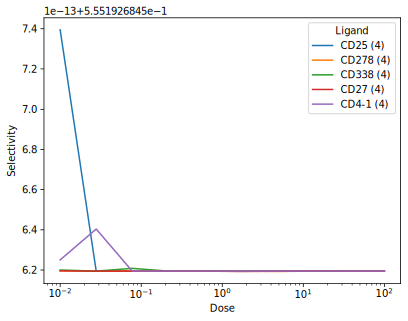

In [ ]:
sns.lineplot(data=df, x="Dose", y="Selectivity", hue="Ligand")
plt.xscale("log")
plt.show()

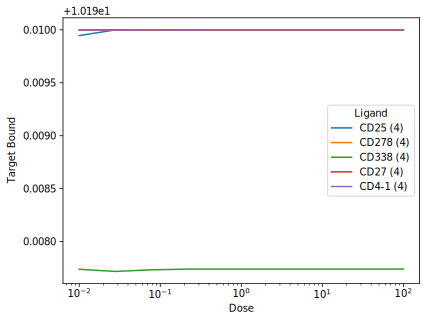

In [ ]:
sns.lineplot(data=df, x="Dose", y="Target Bound", hue="Ligand")
plt.xscale("log")
plt.show()

In [ ]:
%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from bicytok.imports import importCITE, sample_receptor_abundances
from bicytok.selectivity_funcs import get_cell_bindings, optimize_affs

plt.rcParams["svg.fonttype"] = "none"

signal = ["CD122", 2]
all_targets = [
    [("CD25", 2)],
    [("CD278", 2)],
    [("CD338", 2)],
    [("CD27", 2)],
    [("CD4-1", 2)],
]
targ_cell = "Treg"
dose_vec = np.logspace(-2, 2, num=20)

CITE_DF = importCITE()

epitopes = [
    col
    for col in CITE_DF.columns
    if col not in ["CellType1", "CellType2", "CellType3"]
]
epitopes_df = CITE_DF[epitopes + ["CellType2"]]
epitopes_df = epitopes_df.rename(columns={"CellType2": "Cell Type"})

sample_df = sample_receptor_abundances(
    CITE_DF=epitopes_df,
    numCells=100,
    targCellType=targ_cell,
)

df = pd.DataFrame(columns=["Dose", "Selectivity", "Target Bound", "Ligand"])

for target_pairs in all_targets:
    valencies = [signal[1]]
    targets = []
    naming = []
    for target, valency in target_pairs:
        targets.append(target)
        valencies.append(valency)
        naming.append(f"{target} ({valency})")

    valencies = np.array([valencies])

    df_targ_cell = sample_df.loc[sample_df["Cell Type"] == targ_cell]
    targ_recs = df_targ_cell[[signal[0]] + targets]
    df_off_targ_cell = sample_df.loc[sample_df["Cell Type"] != targ_cell]
    off_targ_recs = df_off_targ_cell[[signal[0]] + targets]

    for dose in dose_vec:
        opt_selec, opt_params, _ = optimize_affs(
            targRecs=targ_recs.to_numpy(),
            offTargRecs=off_targ_recs.to_numpy(),
            dose=dose,
            valencies=valencies,
        )

        r_bound = get_cell_bindings(
            recCounts=sample_df[[signal[0]] + targets].to_numpy(),
            monomerAffs=opt_params,
            dose=dose,
            valencies=valencies,
        )

        cell_bind_df = sample_df[[signal[0]] + ["Cell Type"]]
        cell_bind_df.insert(0, "Receptor Bound", r_bound[:, 0], True)
        cell_bind_df = cell_bind_df.groupby(["Cell Type"]).mean(0)

        data = {
            "Dose": [dose],
            "Selectivity": 1 / opt_selec,
            "Target Bound": cell_bind_df["Receptor Bound"].loc[targ_cell],
            "Ligand": " + ".join(naming),
            "Affinities": opt_params,
        }
        df_temp = pd.DataFrame(
            data, columns=["Dose", "Selectivity", "Target Bound", "Ligand"]
        )
        df = df_temp if df.empty else pd.concat([df, df_temp], ignore_index=True)

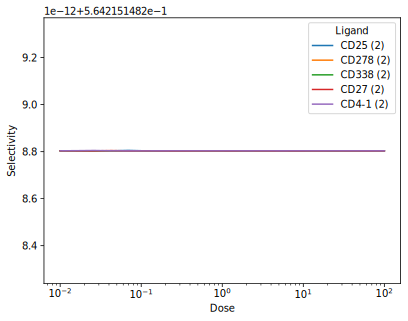

In [ ]:
sns.lineplot(data=df, x="Dose", y="Selectivity", hue="Ligand")
plt.xscale("log")
plt.show()

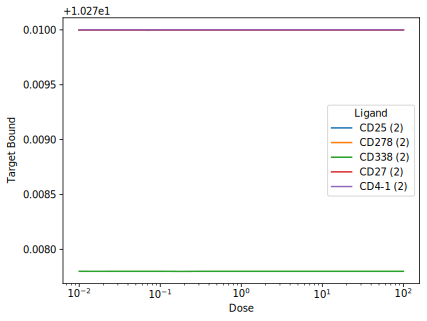

In [ ]:
sns.lineplot(data=df, x="Dose", y="Target Bound", hue="Ligand")
plt.xscale("log")
plt.show()

In [ ]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from bicytok.distance_metric_funcs import KL_EMD_1D
from bicytok.imports import filter_receptor_abundances, importCITE, sample_receptor_abundances
from bicytok.selectivity_funcs import optimize_affs

import time

signal_receptor = "TCR-2"
sample_size = 356*2
targ_cell = "dnT"
test_valencies = [(1), (2)]
dose = 1e-10
cell_categorization = "CellType2"

CITE_DF = importCITE()
assert targ_cell in CITE_DF[cell_categorization].unique()

epitopes = [
    col
    for col in CITE_DF.columns
    if col not in ["Cell", "CellType1", "CellType2", "CellType3"]
]
epitopes_df = CITE_DF[epitopes + [cell_categorization]]
epitopes_df = epitopes_df.rename(columns={cell_categorization: "Cell Type"})
sample_df = sample_receptor_abundances(
    CITE_DF=epitopes_df,
    numCells=min(sample_size, epitopes_df.shape[0]),
    targCellType=targ_cell,
)
filtered_sample_df = filter_receptor_abundances(sample_df, targ_cell, whitelist=[signal_receptor])
epitopes = filtered_sample_df.columns[:-1]

on_target_mask = (filtered_sample_df["Cell Type"] == targ_cell).to_numpy()
off_target_mask = ~on_target_mask

df_targ_cell = filtered_sample_df.loc[on_target_mask]
df_off_targ_cell = filtered_sample_df.loc[off_target_mask]

selectivity_vals = []
KL_div_vals = []
EMD_vals = []
for receptor in epitopes:
    rec_abundances = filtered_sample_df[receptor].to_numpy().reshape(-1, 1)

    KL_div_mat, EMD_mat = KL_EMD_1D(rec_abundances, on_target_mask, off_target_mask)
    KL_div = KL_div_mat[0]
    EMD = EMD_mat[0]
    KL_div_vals.append(KL_div)
    EMD_vals.append(EMD)

    for valency in test_valencies:
        time_start = time.time()

        if np.isnan(KL_div) or np.isnan(EMD):
            selectivity_vals.append(np.nan)
            continue

        model_valencies = np.array([[valency, valency]])
        targ_recs = df_targ_cell[[signal_receptor] + [receptor]].to_numpy()
        off_targ_recs = df_off_targ_cell[[signal_receptor] + [receptor]].to_numpy()
        opt_selec, _, _ = optimize_affs(
            targRecs=targ_recs,
            offTargRecs=off_targ_recs,
            dose=dose,
            valencies=model_valencies,
            
        )
        selectivity_vals.append(1 / opt_selec)

        time_end = time.time()
        print(f"Processing time for {receptor} (Valency {valency}): {time_end - time_start} seconds")

valency_map = {1: "Valency 2", 2: "Valency 4"}
valency_labels = [valency_map[v] for _ in epitopes for v in test_valencies]
metrics_df = pd.DataFrame(
    {
        "Receptor Pair": [
            str(receptor) for receptor in epitopes for _ in test_valencies
        ],
        "Valency": valency_labels,
        "KL Divergence": np.repeat(KL_div_vals, len(test_valencies)),
        "EMD": np.repeat(EMD_vals, len(test_valencies)),
        "Selectivity": selectivity_vals,
    }
)

unique_receptors_df = pd.DataFrame(
    {
        "Receptor Pair": [str(receptor) for receptor in epitopes],
        "KL Divergence": [KL_div_val for KL_div_val in KL_div_vals],
        "EMD": [EMD_val for EMD_val in EMD_vals],
    }
)
unique_receptors_df = unique_receptors_df.fillna(0)

Processing time for CD138-1 (Valency 1): 25.928431510925293 seconds
Processing time for CD138-1 (Valency 2): 9.306160688400269 seconds
Processing time for CD144 (Valency 1): 11.167879104614258 seconds
Processing time for CD144 (Valency 2): 8.779841184616089 seconds
Processing time for CD2 (Valency 1): 9.484979391098022 seconds
Processing time for CD2 (Valency 2): 8.297715902328491 seconds
Processing time for CD200 (Valency 1): 7.4735565185546875 seconds
Processing time for CD200 (Valency 2): 11.531367063522339 seconds
Processing time for CD202b (Valency 1): 8.025609970092773 seconds
Processing time for CD202b (Valency 2): 9.571703910827637 seconds
Processing time for CD27 (Valency 1): 22.31795907020569 seconds
Processing time for CD27 (Valency 2): 6.422053813934326 seconds
Processing time for CD275-1 (Valency 1): 10.272887706756592 seconds
Processing time for CD275-1 (Valency 2): 6.760418891906738 seconds
Processing time for CD278 (Valency 1): 27.98138403892517 seconds
Processing time 

In [ ]:
# Get top 7 receptors for each metric (each receptor counted once)
top_kl_indices = unique_receptors_df["KL Divergence"].nlargest(7).index.tolist()
top_kl_receptors = unique_receptors_df.iloc[top_kl_indices][
    "Receptor Pair"
].tolist()

top_emd_indices = unique_receptors_df["EMD"].nlargest(7).index.tolist()
top_emd_receptors = unique_receptors_df.iloc[top_emd_indices][
    "Receptor Pair"
].tolist()

# Get top 7 selectivity receptors (taking best selectivity per receptor across valencies)
selectivity_per_receptor = metrics_df.dropna(subset=["Selectivity"]).groupby("Receptor Pair")["Selectivity"].max().reset_index()
top_selectivity_data = selectivity_per_receptor.nlargest(7, "Selectivity")
top_selectivity_receptors = top_selectivity_data["Receptor Pair"].tolist()

# Create categories for KL plot
kl_both = set(top_kl_receptors).intersection(set(top_selectivity_receptors))
kl_only = set(top_kl_receptors) - set(top_selectivity_receptors)
selectivity_only_kl = set(top_selectivity_receptors) - set(top_kl_receptors)

# Create categories for EMD plot
emd_both = set(top_emd_receptors).intersection(set(top_selectivity_receptors))
emd_only = set(top_emd_receptors) - set(top_selectivity_receptors)
selectivity_only_emd = set(top_selectivity_receptors) - set(top_emd_receptors)

# Filter dataframes for KL plot categories
metrics_df_kl_both = metrics_df[metrics_df["Receptor Pair"].isin(kl_both)]
metrics_df_kl_only = metrics_df[metrics_df["Receptor Pair"].isin(kl_only)]
metrics_df_selectivity_only_kl = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_kl)]

# Filter dataframes for EMD plot categories
metrics_df_emd_both = metrics_df[metrics_df["Receptor Pair"].isin(emd_both)]
metrics_df_emd_only = metrics_df[metrics_df["Receptor Pair"].isin(emd_only)]
metrics_df_selectivity_only_emd = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_emd)]

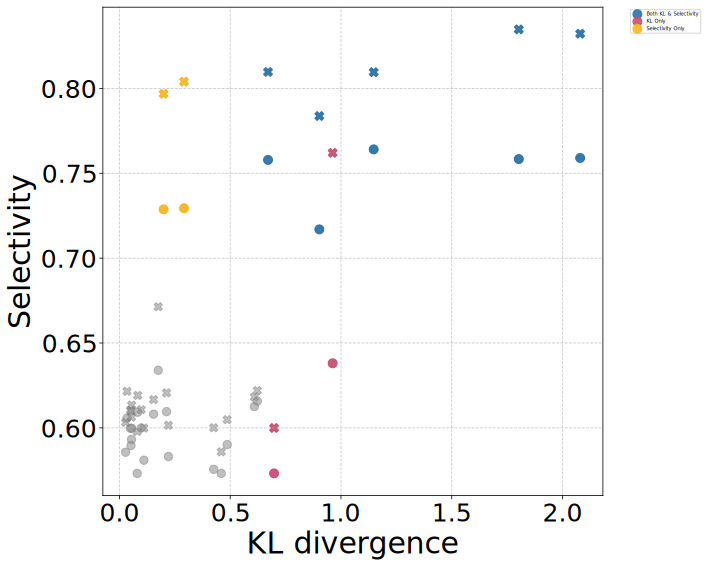

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
# Plot all receptors in gray with specific markers by valency
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["KL Divergence"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL divergence", fontsize=30)
ax.set_ylabel("Selectivity", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=5)
plt.tight_layout()
plt.show()

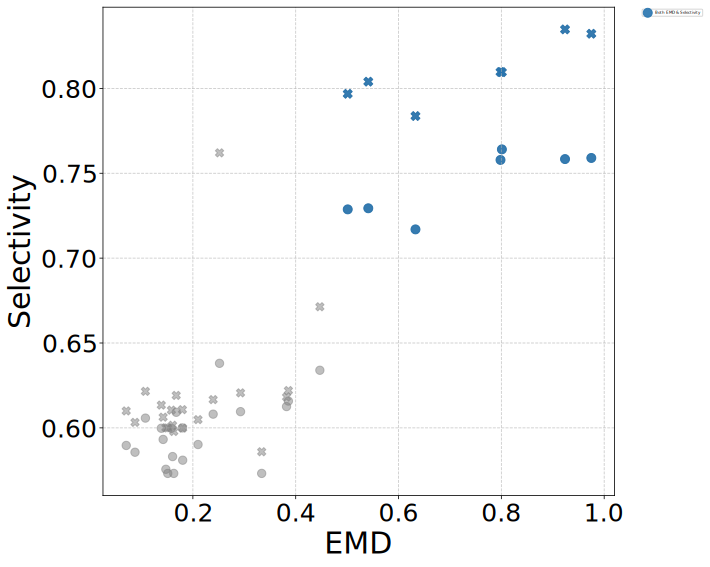

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["EMD"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both EMD and selectivity (blue)
if len(metrics_df_emd_both) > 0:
    for valency in metrics_df_emd_both["Valency"].unique():
        subset = metrics_df_emd_both[metrics_df_emd_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both EMD & Selectivity" if valency == metrics_df_emd_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by EMD (red)
if len(metrics_df_emd_only) > 0:
    for valency in metrics_df_emd_only["Valency"].unique():
        subset = metrics_df_emd_only[metrics_df_emd_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="EMD Only" if valency == metrics_df_emd_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_emd) > 0:
    for valency in metrics_df_selectivity_only_emd["Valency"].unique():
        subset = metrics_df_selectivity_only_emd[metrics_df_selectivity_only_emd["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_emd["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("EMD", fontsize=30)
ax.set_ylabel("Selectivity", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
# ax.set_title("EMD vs Selectivity (Top 5 Receptors by Category)", fontsize=30)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=4)
plt.tight_layout()
plt.show()

In [ ]:
%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from bicytok.imports import importCITE, sample_receptor_abundances
from bicytok.selectivity_funcs import get_cell_bindings, optimize_affs

plt.rcParams["svg.fonttype"] = "none"

signal = ["CD122", 2]
all_targets = [
    [("CD25", 2)],
    [("CD278", 2)],
    [("CD338", 2)],
    [("CD27", 2)],
    [("CD4-1", 2)],
]
targ_cell = "Treg"
dose_vec = np.logspace(-12, -8, num=20)

CITE_DF = importCITE()

epitopes = [
    col
    for col in CITE_DF.columns
    if col not in ["CellType1", "CellType2", "CellType3"]
]
epitopes_df = CITE_DF[epitopes + ["CellType2"]]
epitopes_df = epitopes_df.rename(columns={"CellType2": "Cell Type"})

sample_df = sample_receptor_abundances(
    CITE_DF=epitopes_df,
    numCells=100,
    targCellType=targ_cell,
)

df = pd.DataFrame(columns=["Dose", "Selectivity", "Target Bound", "Ligand"])

for target_pairs in all_targets:
    valencies = [signal[1]]
    targets = []
    naming = []
    for target, valency in target_pairs:
        targets.append(target)
        valencies.append(valency)
        naming.append(f"{target} ({valency})")

    valencies = np.array([valencies])

    df_targ_cell = sample_df.loc[sample_df["Cell Type"] == targ_cell]
    targ_recs = df_targ_cell[[signal[0]] + targets]
    df_off_targ_cell = sample_df.loc[sample_df["Cell Type"] != targ_cell]
    off_targ_recs = df_off_targ_cell[[signal[0]] + targets]

    for dose in dose_vec:
        opt_selec, opt_params, _ = optimize_affs(
            targRecs=targ_recs.to_numpy(),
            offTargRecs=off_targ_recs.to_numpy(),
            dose=dose,
            valencies=valencies,
        )

        r_bound = get_cell_bindings(
            recCounts=sample_df[[signal[0]] + targets].to_numpy(),
            monomerAffs=opt_params,
            dose=dose,
            valencies=valencies,
        )

        cell_bind_df = sample_df[[signal[0]] + ["Cell Type"]]
        cell_bind_df.insert(0, "Receptor Bound", r_bound[:, 0], True)
        cell_bind_df = cell_bind_df.groupby(["Cell Type"]).mean(0)

        data = {
            "Dose": [dose],
            "Selectivity": 1 / opt_selec,
            "Target Bound": cell_bind_df["Receptor Bound"].loc[targ_cell],
            "Ligand": " + ".join(naming),
            "Affinities": opt_params,
        }
        df_temp = pd.DataFrame(
            data, columns=["Dose", "Selectivity", "Target Bound", "Ligand"]
        )
        df = df_temp if df.empty else pd.concat([df, df_temp], ignore_index=True)

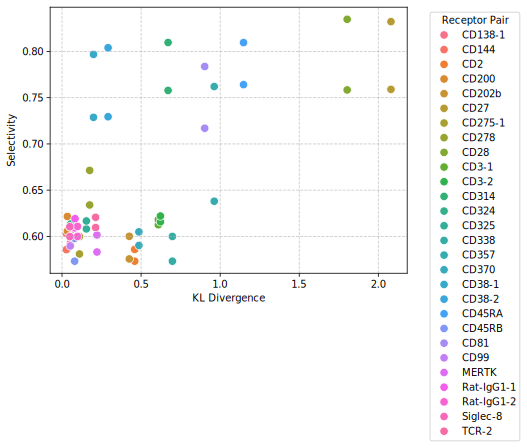

In [ ]:
sns.scatterplot(
    data=metrics_df,
    x="KL Divergence",
    y="Selectivity",
    hue="Receptor Pair",
    s=70,
    legend=True,
)

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), title="Receptor Pair")
plt.show()

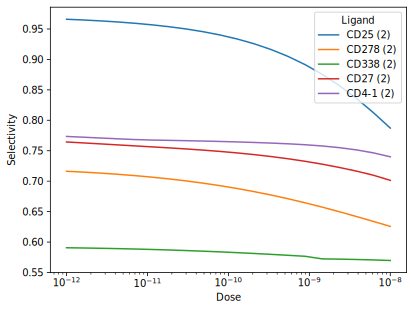

In [ ]:
sns.lineplot(data=df, x="Dose", y="Selectivity", hue="Ligand")
plt.xscale("log")
plt.show()

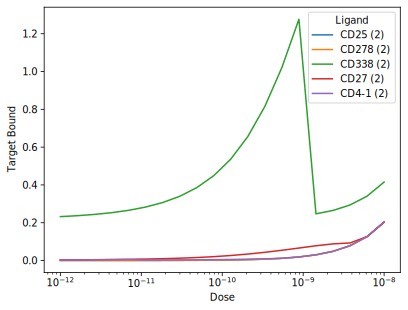

In [ ]:
sns.lineplot(data=df, x="Dose", y="Target Bound", hue="Ligand")
plt.xscale("log")
plt.show()

In [ ]:
%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from bicytok.imports import importCITE, sample_receptor_abundances
from bicytok.selectivity_funcs import get_cell_bindings, optimize_affs

plt.rcParams["svg.fonttype"] = "none"

signal = ["CD122", 2]
all_targets = [
    [("CD25", 2)],
    [("CD278", 2)],
    [("CD338", 2)],
    [("CD27", 2)],
    [("CD4-1", 2)],
]
targ_cell = "Treg"
dose_vec = np.logspace(-11, -4, num=20)

CITE_DF = importCITE()

epitopes = [
    col
    for col in CITE_DF.columns
    if col not in ["CellType1", "CellType2", "CellType3"]
]
epitopes_df = CITE_DF[epitopes + ["CellType2"]]
epitopes_df = epitopes_df.rename(columns={"CellType2": "Cell Type"})

sample_df = sample_receptor_abundances(
    CITE_DF=epitopes_df,
    numCells=100,
    targCellType=targ_cell,
)

df = pd.DataFrame(columns=["Dose", "Selectivity", "Target Bound", "Ligand"])

for target_pairs in all_targets:
    valencies = [signal[1]]
    targets = []
    naming = []
    for target, valency in target_pairs:
        targets.append(target)
        valencies.append(valency)
        naming.append(f"{target} ({valency})")

    valencies = np.array([valencies])

    df_targ_cell = sample_df.loc[sample_df["Cell Type"] == targ_cell]
    targ_recs = df_targ_cell[[signal[0]] + targets]
    df_off_targ_cell = sample_df.loc[sample_df["Cell Type"] != targ_cell]
    off_targ_recs = df_off_targ_cell[[signal[0]] + targets]

    for dose in dose_vec:
        opt_selec, opt_params, _ = optimize_affs(
            targRecs=targ_recs.to_numpy(),
            offTargRecs=off_targ_recs.to_numpy(),
            dose=dose,
            valencies=valencies,
        )

        r_bound = get_cell_bindings(
            recCounts=sample_df[[signal[0]] + targets].to_numpy(),
            monomerAffs=opt_params,
            dose=dose,
            valencies=valencies,
        )

        cell_bind_df = sample_df[[signal[0]] + ["Cell Type"]]
        cell_bind_df.insert(0, "Receptor Bound", r_bound[:, 0], True)
        cell_bind_df = cell_bind_df.groupby(["Cell Type"]).mean(0)

        data = {
            "Dose": [dose],
            "Selectivity": 1 / opt_selec,
            "Target Bound": cell_bind_df["Receptor Bound"].loc[targ_cell],
            "Ligand": " + ".join(naming),
            "Affinities": opt_params,
        }
        df_temp = pd.DataFrame(
            data, columns=["Dose", "Selectivity", "Target Bound", "Ligand"]
        )
        df = df_temp if df.empty else pd.concat([df, df_temp], ignore_index=True)

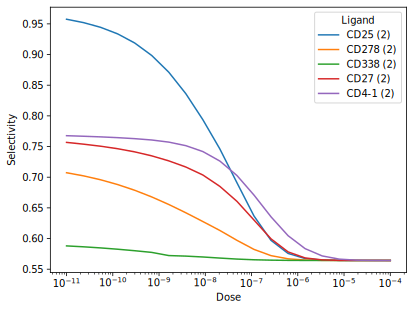

In [ ]:
sns.lineplot(data=df, x="Dose", y="Selectivity", hue="Ligand")
plt.xscale("log")
plt.show()

In [ ]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from bicytok.distance_metric_funcs import KL_EMD_1D
from bicytok.imports import filter_receptor_abundances, importCITE, sample_receptor_abundances
from bicytok.selectivity_funcs import optimize_affs

import time

signal_receptor = "TCR-1"
sample_size = 356*2
targ_cell = "dnT"
test_valencies = [(1), (2)]
dose = 1e-10
cell_categorization = "CellType2"

CITE_DF = importCITE()
assert targ_cell in CITE_DF[cell_categorization].unique()

epitopes = [
    col
    for col in CITE_DF.columns
    if col not in ["Cell", "CellType1", "CellType2", "CellType3"]
]
epitopes_df = CITE_DF[epitopes + [cell_categorization]]
epitopes_df = epitopes_df.rename(columns={cell_categorization: "Cell Type"})
sample_df = sample_receptor_abundances(
    CITE_DF=epitopes_df,
    numCells=min(sample_size, epitopes_df.shape[0]),
    targCellType=targ_cell,
)
filtered_sample_df = filter_receptor_abundances(sample_df, targ_cell, whitelist=[signal_receptor])
epitopes = filtered_sample_df.columns[:-1]

on_target_mask = (filtered_sample_df["Cell Type"] == targ_cell).to_numpy()
off_target_mask = ~on_target_mask

df_targ_cell = filtered_sample_df.loc[on_target_mask]
df_off_targ_cell = filtered_sample_df.loc[off_target_mask]

selectivity_vals = []
KL_div_vals = []
EMD_vals = []
for receptor in epitopes:
    rec_abundances = filtered_sample_df[receptor].to_numpy().reshape(-1, 1)

    KL_div_mat, EMD_mat = KL_EMD_1D(rec_abundances, on_target_mask, off_target_mask)
    KL_div = KL_div_mat[0]
    EMD = EMD_mat[0]
    KL_div_vals.append(KL_div)
    EMD_vals.append(EMD)

    for valency in test_valencies:
        time_start = time.time()

        if np.isnan(KL_div) or np.isnan(EMD):
            selectivity_vals.append(np.nan)
            continue

        model_valencies = np.array([[valency, valency]])
        targ_recs = df_targ_cell[[signal_receptor] + [receptor]].to_numpy()
        off_targ_recs = df_off_targ_cell[[signal_receptor] + [receptor]].to_numpy()
        opt_selec, _, _ = optimize_affs(
            targRecs=targ_recs,
            offTargRecs=off_targ_recs,
            dose=dose,
            valencies=model_valencies,
            
        )
        selectivity_vals.append(1 / opt_selec)

        time_end = time.time()
        print(f"Processing time for {receptor} (Valency {valency}): {time_end - time_start} seconds")

valency_map = {1: "Valency 2", 2: "Valency 4"}
valency_labels = [valency_map[v] for _ in epitopes for v in test_valencies]
metrics_df = pd.DataFrame(
    {
        "Receptor Pair": [
            str(receptor) for receptor in epitopes for _ in test_valencies
        ],
        "Valency": valency_labels,
        "KL Divergence": np.repeat(KL_div_vals, len(test_valencies)),
        "EMD": np.repeat(EMD_vals, len(test_valencies)),
        "Selectivity": selectivity_vals,
    }
)

unique_receptors_df = pd.DataFrame(
    {
        "Receptor Pair": [str(receptor) for receptor in epitopes],
        "KL Divergence": [KL_div_val for KL_div_val in KL_div_vals],
        "EMD": [EMD_val for EMD_val in EMD_vals],
    }
)
unique_receptors_df = unique_receptors_df.fillna(0)

Processing time for CD138-1 (Valency 1): 5.868732452392578 seconds
Processing time for CD138-1 (Valency 2): 7.827095031738281 seconds
Processing time for CD144 (Valency 1): 8.640605688095093 seconds
Processing time for CD144 (Valency 2): 11.768247842788696 seconds
Processing time for CD2 (Valency 1): 16.214714765548706 seconds
Processing time for CD2 (Valency 2): 5.168148040771484 seconds
Processing time for CD200 (Valency 1): 11.619362831115723 seconds
Processing time for CD200 (Valency 2): 7.220803499221802 seconds
Processing time for CD202b (Valency 1): 7.512909412384033 seconds
Processing time for CD202b (Valency 2): 7.687017202377319 seconds
Processing time for CD27 (Valency 1): 31.707213163375854 seconds
Processing time for CD27 (Valency 2): 6.331013441085815 seconds
Processing time for CD275-1 (Valency 1): 13.273623943328857 seconds
Processing time for CD275-1 (Valency 2): 31.715248584747314 seconds
Processing time for CD278 (Valency 1): 12.01790714263916 seconds
Processing time

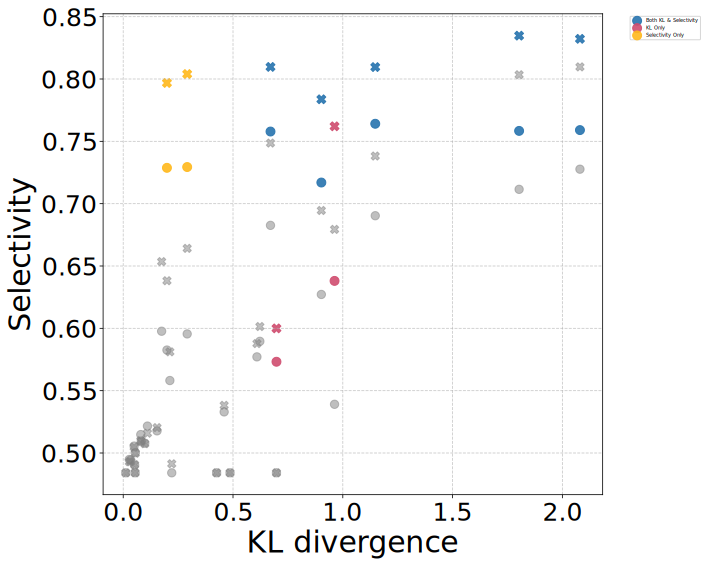

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
# Plot all receptors in gray with specific markers by valency
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["KL Divergence"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL divergence", fontsize=30)
ax.set_ylabel("Selectivity", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=5)
plt.tight_layout()
plt.show()

In [ ]:
# Get top 7 receptors for each metric (each receptor counted once)
top_kl_indices = unique_receptors_df["KL Divergence"].nlargest(7).index.tolist()
top_kl_receptors = unique_receptors_df.iloc[top_kl_indices][
    "Receptor Pair"
].tolist()

top_emd_indices = unique_receptors_df["EMD"].nlargest(7).index.tolist()
top_emd_receptors = unique_receptors_df.iloc[top_emd_indices][
    "Receptor Pair"
].tolist()

# Get top 7 selectivity receptors (taking best selectivity per receptor across valencies)
selectivity_per_receptor = metrics_df.dropna(subset=["Selectivity"]).groupby("Receptor Pair")["Selectivity"].max().reset_index()
top_selectivity_data = selectivity_per_receptor.nlargest(7, "Selectivity")
top_selectivity_receptors = top_selectivity_data["Receptor Pair"].tolist()

# Create categories for KL plot
kl_both = set(top_kl_receptors).intersection(set(top_selectivity_receptors))
kl_only = set(top_kl_receptors) - set(top_selectivity_receptors)
selectivity_only_kl = set(top_selectivity_receptors) - set(top_kl_receptors)

# Create categories for EMD plot
emd_both = set(top_emd_receptors).intersection(set(top_selectivity_receptors))
emd_only = set(top_emd_receptors) - set(top_selectivity_receptors)
selectivity_only_emd = set(top_selectivity_receptors) - set(top_emd_receptors)

# Filter dataframes for KL plot categories
metrics_df_kl_both = metrics_df[metrics_df["Receptor Pair"].isin(kl_both)]
metrics_df_kl_only = metrics_df[metrics_df["Receptor Pair"].isin(kl_only)]
metrics_df_selectivity_only_kl = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_kl)]

# Filter dataframes for EMD plot categories
metrics_df_emd_both = metrics_df[metrics_df["Receptor Pair"].isin(emd_both)]
metrics_df_emd_only = metrics_df[metrics_df["Receptor Pair"].isin(emd_only)]
metrics_df_selectivity_only_emd = metrics_df[metrics_df["Receptor Pair"].isin(selectivity_only_emd)]

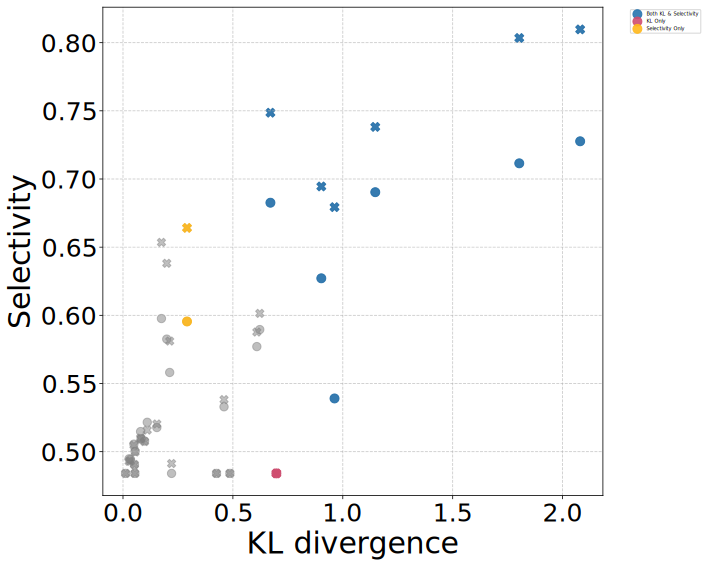

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
# Plot all receptors in gray with specific markers by valency
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["KL Divergence"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both KL and selectivity (blue)
if len(metrics_df_kl_both) > 0:
    for valency in metrics_df_kl_both["Valency"].unique():
        subset = metrics_df_kl_both[metrics_df_kl_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both KL & Selectivity" if valency == metrics_df_kl_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by KL (red)
if len(metrics_df_kl_only) > 0:
    for valency in metrics_df_kl_only["Valency"].unique():
        subset = metrics_df_kl_only[metrics_df_kl_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="KL Only" if valency == metrics_df_kl_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_kl) > 0:
    for valency in metrics_df_selectivity_only_kl["Valency"].unique():
        subset = metrics_df_selectivity_only_kl[metrics_df_selectivity_only_kl["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["KL Divergence"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_kl["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("KL divergence", fontsize=30)
ax.set_ylabel("Selectivity", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=5)
plt.tight_layout()
plt.show()

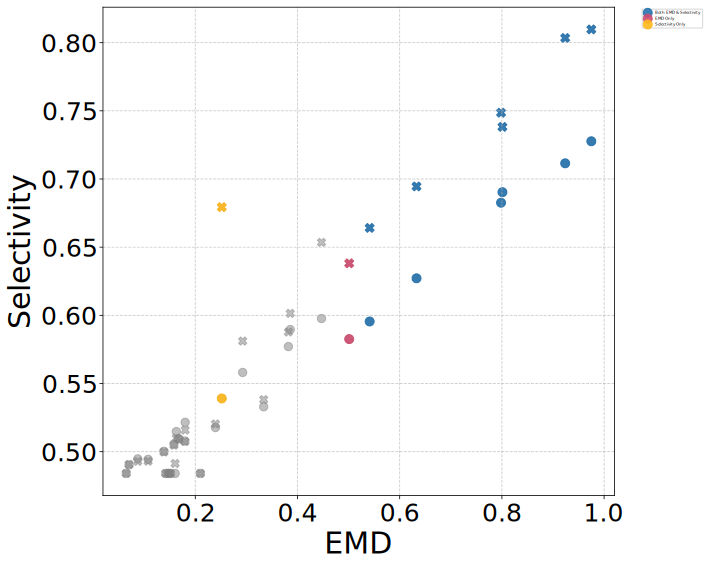

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["EMD"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both EMD and selectivity (blue)
if len(metrics_df_emd_both) > 0:
    for valency in metrics_df_emd_both["Valency"].unique():
        subset = metrics_df_emd_both[metrics_df_emd_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both EMD & Selectivity" if valency == metrics_df_emd_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by EMD (red)
if len(metrics_df_emd_only) > 0:
    for valency in metrics_df_emd_only["Valency"].unique():
        subset = metrics_df_emd_only[metrics_df_emd_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="EMD Only" if valency == metrics_df_emd_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_emd) > 0:
    for valency in metrics_df_selectivity_only_emd["Valency"].unique():
        subset = metrics_df_selectivity_only_emd[metrics_df_selectivity_only_emd["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_emd["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("EMD", fontsize=30)
ax.set_ylabel("Selectivity", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
# ax.set_title("EMD vs Selectivity (Top 5 Receptors by Category)", fontsize=30)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=4)
plt.tight_layout()
plt.show()

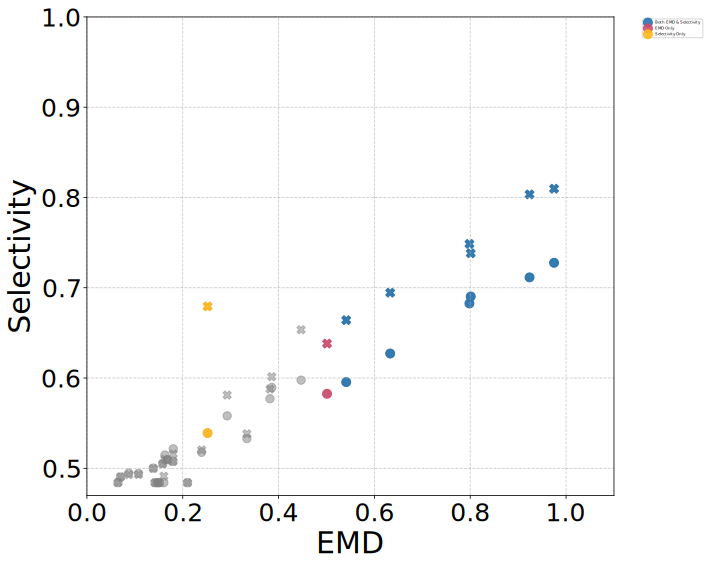

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["EMD"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both EMD and selectivity (blue)
if len(metrics_df_emd_both) > 0:
    for valency in metrics_df_emd_both["Valency"].unique():
        subset = metrics_df_emd_both[metrics_df_emd_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both EMD & Selectivity" if valency == metrics_df_emd_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by EMD (red)
if len(metrics_df_emd_only) > 0:
    for valency in metrics_df_emd_only["Valency"].unique():
        subset = metrics_df_emd_only[metrics_df_emd_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="EMD Only" if valency == metrics_df_emd_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_emd) > 0:
    for valency in metrics_df_selectivity_only_emd["Valency"].unique():
        subset = metrics_df_selectivity_only_emd[metrics_df_selectivity_only_emd["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_emd["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("EMD", fontsize=30)
ax.set_ylabel("Selectivity", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.set_xlim(0, 1.1)
ax.set_ylim(0.47, 1.0)
# ax.set_title("EMD vs Selectivity (Top 5 Receptors by Category)", fontsize=30)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=4)
plt.tight_layout()
plt.show()

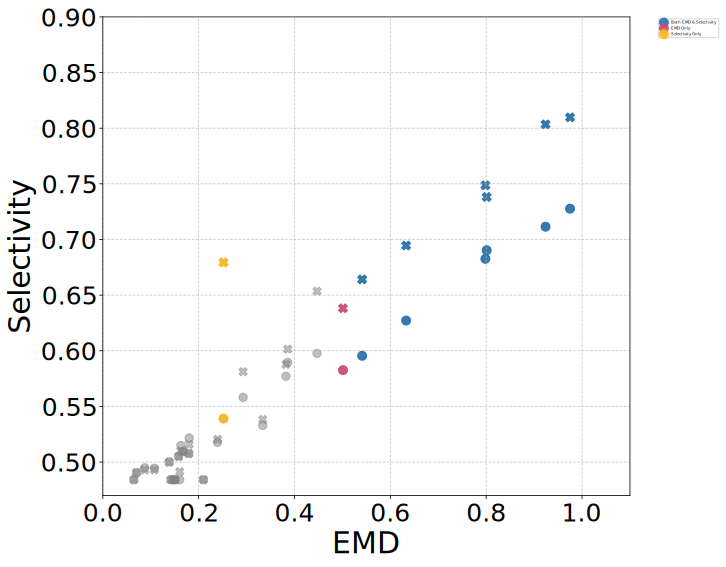

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all receptors in gray
for valency in metrics_df["Valency"].unique():
    subset = metrics_df[metrics_df["Valency"] == valency]
    marker = 'o' if valency == "Valency 2" else 'X'
    ax.scatter(
        subset["EMD"],
        subset["Selectivity"],
        marker=marker,
        s=70,
        color='gray',
        alpha=0.5
    )

# Plot receptors identified by both EMD and selectivity (blue)
if len(metrics_df_emd_both) > 0:
    for valency in metrics_df_emd_both["Valency"].unique():
        subset = metrics_df_emd_both[metrics_df_emd_both["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#2774AE",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Both EMD & Selectivity" if valency == metrics_df_emd_both["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by EMD (red)
if len(metrics_df_emd_only) > 0:
    for valency in metrics_df_emd_only["Valency"].unique():
        subset = metrics_df_emd_only[metrics_df_emd_only["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#CF4D6F",
            s=80,
            alpha=0.9,
            marker=marker,
            label="EMD Only" if valency == metrics_df_emd_only["Valency"].unique()[0] else ""
        )

# Plot receptors identified only by selectivity (yellow)
if len(metrics_df_selectivity_only_emd) > 0:
    for valency in metrics_df_selectivity_only_emd["Valency"].unique():
        subset = metrics_df_selectivity_only_emd[metrics_df_selectivity_only_emd["Valency"] == valency]
        marker = 'o' if valency == "Valency 2" else 'X'
        ax.scatter(
            subset["EMD"],
            subset["Selectivity"],
            color="#FFB81C",
            s=80,
            alpha=0.9,
            marker=marker,
            label="Selectivity Only" if valency == metrics_df_selectivity_only_emd["Valency"].unique()[0] else ""
        )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("EMD", fontsize=30)
ax.set_ylabel("Selectivity", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.set_xlim(0, 1.1)
ax.set_ylim(0.47, 0.9)
# ax.set_title("EMD vs Selectivity (Top 5 Receptors by Category)", fontsize=30)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=4)
plt.tight_layout()
plt.show()